## Importing Libraries

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import cv2
import math
import os
import zipfile
import random
import shutil
import Augmentor
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import display

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
from google.colab import drive # Import the Google Drive module to access files stored in your Drive account
drive.mount('/content/drive') # Mount Google Drive to the Colab environment so you can read and write files

Mounted at /content/drive


## EDA

In [ ]:
zip_path = '/content/drive/MyDrive/brain_tumor_object_detection.zip' # Define the path to the ZIP file containing the brain tumor dataset
extract_path = '/content/drive/MyDrive/brain_tumor_object_detection/data' # Define the folder path where the dataset will be extracted

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path) # Extract the contents of the ZIP file into the specified directory

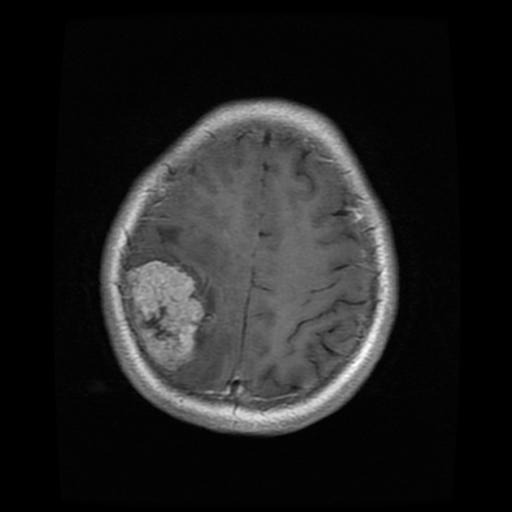

In [ ]:
sample_image = Image.open('/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/meningioma/Tr-me_0011.jpg')
sample_image # Load and display a sample MRI image from the extracted dataset

In [ ]:
sample_image.size

(512, 512)

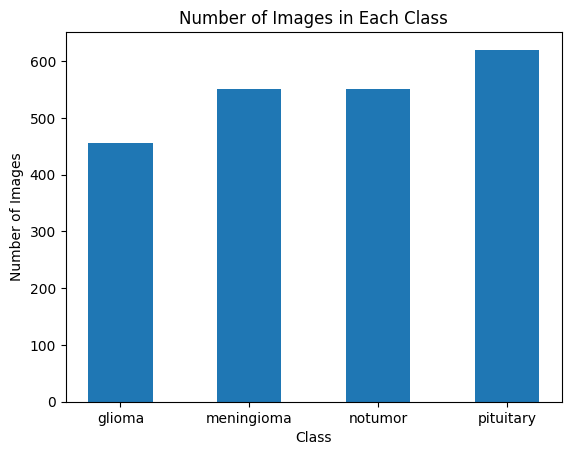

In [ ]:
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']
class_counts = [456, 551, 550, 620]

plt.bar(class_names, class_counts, width=0.5)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.show() #Visualizes the number of MRI images available for each brain tumor class to check dataset balance.

## Train-Test Split

In [ ]:
import os
import shutil
from sklearn.model_selection import train_test_split

def custom_train_val_test_split(dataset_directory, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=None, min_samples_per_class=2):
    """
    Custom function to perform a stratified train-validation-test split on an image dataset.
    This function organizes the dataset into 'train', 'val', and 'test' directories while maintaining the class-wise distribution.
    It creates the 'train', 'val', and 'test' directories within the given dataset directory and moves images accordingly.
    """
    random_seed = random_seed or 42

    # List class directories (e.g., subdirectories representing each class)
    class_directories = [d for d in os.listdir(dataset_directory) if os.path.isdir(os.path.join(dataset_directory, d))]

    # Create directories for train, validation, and test sets
    train_directory = os.path.join(dataset_directory, 'train')
    val_directory = os.path.join(dataset_directory, 'val')
    test_directory = os.path.join(dataset_directory, 'test')

    os.makedirs(train_directory, exist_ok=True)
    os.makedirs(val_directory, exist_ok=True)
    os.makedirs(test_directory, exist_ok=True)

    for class_dir in class_directories:
        class_path = os.path.join(dataset_directory, class_dir)

        # Get the list of image files in the class directory
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]

        # Skip classes with fewer than the minimum required samples
        if len(image_files) < min_samples_per_class:
            continue

        # Split images into train and (val + test)
        train_images, remaining_images = train_test_split(image_files, test_size=1 - train_ratio, random_state=random_seed)

        # Split remaining images into validation and test
        val_images, test_images = train_test_split(remaining_images, test_size=test_ratio / (test_ratio + val_ratio), random_state=random_seed)

        # Move training images
        for image in train_images:
            src_image_path = os.path.join(class_path, image)
            src_annotation_path = os.path.join(class_path, image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(train_directory, class_dir, image)
            dest_annotation_path = os.path.join(train_directory, class_dir, image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        # Move validation images
        for image in val_images:
            src_image_path = os.path.join(class_path, image)
            src_annotation_path = os.path.join(class_path, image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(val_directory, class_dir, image)
            dest_annotation_path = os.path.join(val_directory, class_dir, image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)

        # Move test images
        for image in test_images:
            src_image_path = os.path.join(class_path, image)
            src_annotation_path = os.path.join(class_path, image.replace('.jpg', '.txt'))

            dest_image_path = os.path.join(test_directory, class_dir, image)
            dest_annotation_path = os.path.join(test_directory, class_dir, image.replace('.jpg', '.txt'))

            os.makedirs(os.path.dirname(dest_image_path), exist_ok=True)

            if os.path.exists(src_annotation_path):
                shutil.move(src_image_path, dest_image_path)
                shutil.move(src_annotation_path, dest_annotation_path)



In [ ]:
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'

custom_train_val_test_split(dataset_directory, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, random_seed=42, min_samples_per_class=2)


###Count images per class

In [ ]:
def count_images_per_class(directory):
    class_counts = {}
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            class_counts[class_dir] = len([f for f in os.listdir(class_path) if f.endswith('.jpg')])
    return class_counts # function to count the images per class

In [ ]:
import os
import matplotlib.pyplot as plt

def count_images_per_class(directory):
    """
    Count the number of images in each class within the given directory.
    Assumes that the directory contains subdirectories where each subdirectory represents a class.
    """
    class_counts = {}
    class_directories = [d for d in os.listdir(directory) if os.path.isdir(os.path.join(directory, d))]

    for class_dir in class_directories:
        class_path = os.path.join(directory, class_dir)
        image_files = [f for f in os.listdir(class_path) if f.endswith('.jpg')]
        class_counts[class_dir] = len(image_files)

    return class_counts

def plot_image_counts(train_directory, val_directory, test_directory):
    """
    Plot the number of images in each class for the train, validation, and test sets.
    This function counts the number of images in each class for each set
    and plots a bar chart to visualize the distribution.
    """
    train_counts = count_images_per_class(train_directory)
    val_counts = count_images_per_class(val_directory)
    test_counts = count_images_per_class(test_directory)

    class_names = list(train_counts.keys())
    train_counts_values = list(train_counts.values())
    val_counts_values = [val_counts.get(class_name, 0) for class_name in class_names]  # Default to 0 if the class is not in val
    test_counts_values = [test_counts.get(class_name, 0) for class_name in class_names]  # Default to 0 if the class is not in test

    bar_width = 0.25
    index = range(len(class_names))

    fig, ax = plt.subplots()
    bar1 = ax.bar(index, train_counts_values, bar_width, label='Train')
    bar2 = ax.bar([i + bar_width for i in index], val_counts_values, bar_width, label='Validation')
    bar3 = ax.bar([i + 2 * bar_width for i in index], test_counts_values, bar_width, label='Test')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Images')
    ax.set_title('Number of Images in Each Class for Train, Validation, and Test Sets')
    ax.set_xticks([i + bar_width for i in index])
    ax.set_xticklabels(class_names)
    ax.legend()

    plt.show()


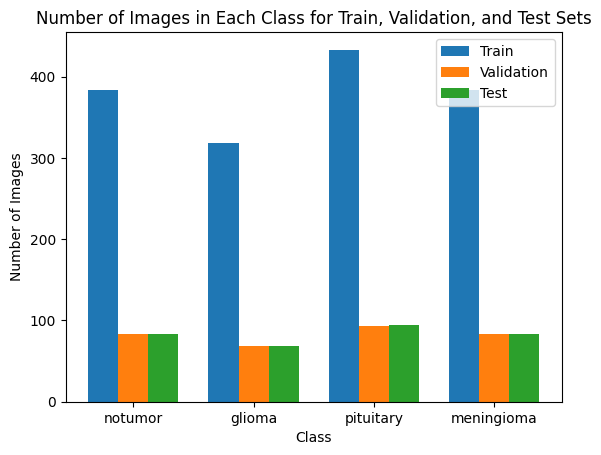

In [ ]:
dataset_directory = '/content/drive/MyDrive/brain_tumor_object_detection/data/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
train_directory = os.path.join(dataset_directory, 'train')
val_directory = os.path.join(dataset_directory, 'val')
test_directory = os.path.join(dataset_directory, 'test')

plot_image_counts(train_directory, val_directory, test_directory) #plot number of images per class

Create yaml file

In [ ]:
yaml_text = """\
path: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/

train: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/train
val: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/val
test: /content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/test

names:
  0: pituitary
  1: meningioma
  2: glioma
  3: notumor
"""

# Save YAML file
yaml_path = "/content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml"
with open(yaml_path, "w") as f:
    f.write(yaml_text)

print("✅ YAML file saved at:", yaml_path)


✅ YAML file saved at: /content/drive/MyDrive/brain_tumor_object_detection/brain_tumor_dataset.yaml


## Prepare Dataset for ResNet Training



In [8]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Define image transformations for ResNet
# Resizing images to 224x224 pixels, converting to PyTorch tensors,
# and normalizing with ImageNet mean and std values.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Define paths to the dataset directories
base_path = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
train_dir = base_path + 'train'
val_dir = base_path + 'val'
test_dir = base_path + 'test'

# 3. Create ImageFolder datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# 4. Create DataLoader instances
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Dataset preparation complete: train_loader, val_loader, and test_loader created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Dataset preparation complete: train_loader, val_loader, and test_loader created.
Number of training samples: 1519
Number of validation samples: 329
Number of test samples: 327
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Load Pre-trained ResNet Model




In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Load a pre-trained ResNet model (e.g., ResNet50)
resnet_model = models.resnet50(pretrained=True)

# Freeze all parameters in the network
for param in resnet_model.parameters():
    param.requires_grad = False

# 2. Get the number of input features for the final fully connected layer
num_ftrs = resnet_model.fc.in_features

# 3. Create a new final fully connected layer with 4 output classes
num_classes = len(train_dataset.classes) # Assuming train_dataset is already defined and contains class information
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

print(f"Pre-trained ResNet model loaded and final layer modified for {num_classes} classes.")
print(f"Model's final layer: {resnet_model.fc}")


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pre-trained ResNet model loaded and final layer modified for 4 classes.
Model's final layer: Linear(in_features=2048, out_features=4, bias=True)


## Train ResNet Model




In [ ]:
import torch.optim as optim

# 1. Move the resnet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy = 0.0
best_model_wts = resnet_model.state_dict()
early_stopping_counter = 0

print(f"Starting training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    resnet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    resnet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = resnet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nTraining complete!")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")

# Load best model weights into model
resnet_model.load_state_dict(best_model_wts)
print("Best model weights loaded into resnet_model.")

Starting training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 0.9678, Train Acc: 0.6827 | Val Loss: 0.9343, Val Acc: 0.6383
New best model saved with validation accuracy: 0.6383
Epoch 2/40 | Train Loss: 0.5862, Train Acc: 0.8552 | Val Loss: 0.5824, Val Acc: 0.8359
New best model saved with validation accuracy: 0.8359
Epoch 3/40 | Train Loss: 0.4641, Train Acc: 0.8769 | Val Loss: 0.4438, Val Acc: 0.8663
New best model saved with validation accuracy: 0.8663
Epoch 4/40 | Train Loss: 0.4022, Train Acc: 0.8835 | Val Loss: 0.3968, Val Acc: 0.8936
New best model saved with validation accuracy: 0.8936
Epoch 5/40 | Train Loss: 0.3462, Train Acc: 0.9098 | Val Loss: 0.3597, Val Acc: 0.9027
New best model saved with validation accuracy: 0.9027
Epoch 6/40 | Train Loss: 0.3138, Train Acc: 0.9144 | Val Loss: 0.3419, Val Acc: 0.9058
New best model saved with validation accuracy: 0.9058
Epoch 7/40 | Train Loss: 0.2836, Train Acc: 0.9210 | Val Loss: 0.3757, Val Acc: 0.8875
Early st

## Evaluate ResNet Model

### Subtask:
Evaluate the performance of the trained ResNet model on the test dataset using metrics such as accuracy, precision, recall, and F1-score.


**Reasoning**:
The subtask requires evaluating the trained ResNet model on the test dataset using various metrics. I will set the model to evaluation mode, collect predictions, and calculate accuracy, precision, recall, and F1-score as per the instructions.



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. Set the resnet_model to evaluation mode
resnet_model.eval()

# 2. Initialize empty lists to store true labels and predicted labels for the test set
all_labels = []
all_predictions = []

# 3. Iterate through the test_loader, moving inputs and labels to the appropriate device
# 4. For each batch, get model outputs, convert them to predicted class labels, and append both true and predicted labels to their respective lists
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 5. Convert the lists of true and predicted labels into NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 6. Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# 7. Print the calculated evaluation metrics
print("\n--- ResNet Model Evaluation on Test Data ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


--- ResNet Model Evaluation on Test Data ---
Accuracy: 0.9144
Precision: 0.9159
Recall: 0.9144
F1-Score: 0.9133


## Save Trained ResNet Model

### Subtask:
Save the trained ResNet model's state dictionary to your Google Drive for future use.


In [ ]:
import os
import torch

# Define the path to save the model in Google Drive
save_path = '/content/drive/MyDrive/brain_tumor_object_detection/resnet_brain_tumor_model.pth'

# Ensure the directory exists (optional, but good practice)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(resnet_model.state_dict(), save_path)

print(f"Trained ResNet model saved to: {save_path}")

Trained ResNet model saved to: /content/drive/MyDrive/brain_tumor_object_detection/resnet_brain_tumor_model.pth


Resnet model taining performance

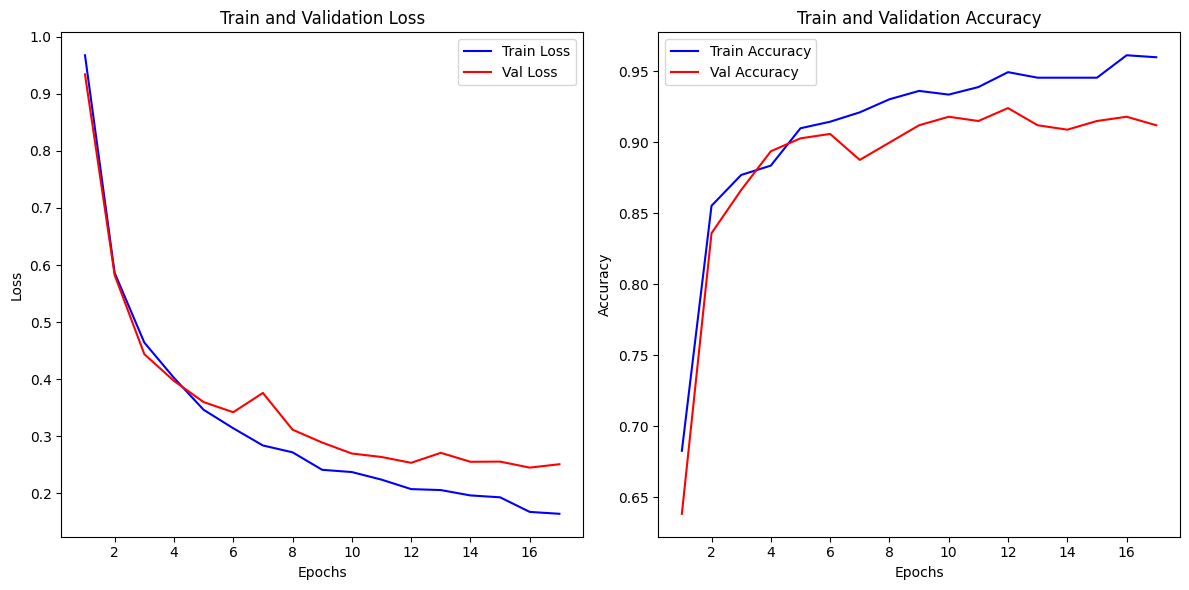

In [ ]:
import matplotlib.pyplot as plt

# Epoch data from the training logs, as extracted from previous output
epochs = list(range(1, 18))  # 1 to 17 epochs (since early stopping happened at epoch 17)
train_loss = [0.9678, 0.5862, 0.4641, 0.4022, 0.3462, 0.3138, 0.2836, 0.2716, 0.2409, 0.2370,
              0.2237, 0.2071, 0.2054, 0.1960, 0.1927, 0.1671, 0.1638]
train_acc = [0.6827, 0.8552, 0.8769, 0.8835, 0.9098, 0.9144, 0.9210, 0.9302, 0.9361, 0.9335,
             0.9388, 0.9493, 0.9454, 0.9454, 0.9454, 0.9612, 0.9598]
val_loss = [0.9343, 0.5824, 0.4438, 0.3968, 0.3597, 0.3419, 0.3757, 0.3113, 0.2887, 0.2695,
            0.2634, 0.2532, 0.2707, 0.2550, 0.2553, 0.2448, 0.2507]
val_acc = [0.6383, 0.8359, 0.8663, 0.8936, 0.9027, 0.9058, 0.8875, 0.8997, 0.9119, 0.9179,
           0.9149, 0.9240, 0.9119, 0.9088, 0.9149, 0.9179, 0.9119]

# Plotting the Losses
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Val Loss', color='red')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Val Accuracy', color='red')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate ResNet Model Class-wise Performance

### Subtask:
Calculate and display class-wise precision, recall, and F1-score for the ResNet model on the test dataset. This will provide a detailed view of the model's performance for each specific brain tumor class.

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate class-wise precision, recall, and F1-score
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels, all_predictions, average=None, labels=np.arange(len(class_names)))

print("\n--- ResNet Model Class-wise Evaluation on Test Data ---")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print("--------------------")


--- ResNet Model Class-wise Evaluation on Test Data ---
Class: glioma
  Precision: 1.0000
  Recall: 0.8971
  F1-Score: 0.9457
--------------------
Class: meningioma
  Precision: 0.8625
  Recall: 0.8313
  F1-Score: 0.8466
--------------------
Class: notumor
  Precision: 0.9000
  Recall: 0.9759
  F1-Score: 0.9364
--------------------
Class: pituitary
  Precision: 0.9271
  Recall: 0.9570
  F1-Score: 0.9418
--------------------


## Visualize ResNet Model Confusion Matrix

### Subtask:
Generate and display a confusion matrix for the ResNet model's predictions on the test dataset. This will provide a detailed view of true positive, true negative, false positive, and false negative classifications for each brain tumor class.

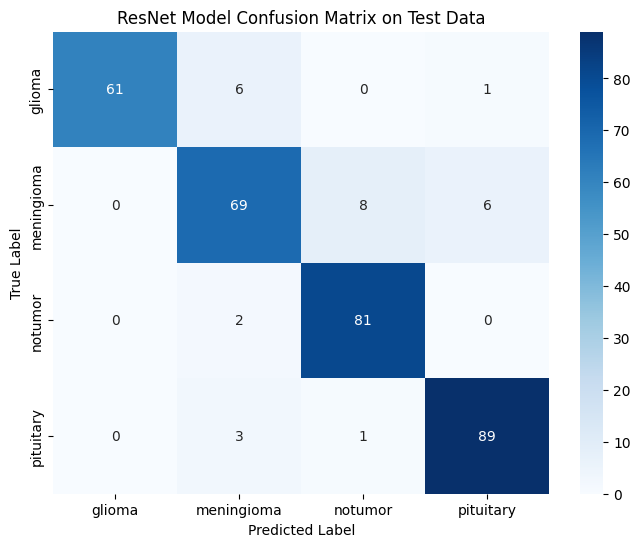

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate the confusion matrix
cm = confusion_matrix(all_labels, all_predictions)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('ResNet Model Confusion Matrix on Test Data')
plt.show()

## Visualize ResNet Model Training and Validation Curves

### Subtask:
Generate and display plots for training/validation loss and training/validation accuracy to visualize the ResNet model's learning progress over epochs.

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. Set the resnet_model to evaluation mode
resnet_model.eval()

# 2. Initialize empty lists to store true labels and predicted labels for the test set
all_labels = []
all_predictions = []

# 3. Iterate through the test_loader, moving inputs and labels to the appropriate device
# 4. For each batch, get model outputs, convert them to predicted class labels, and append both true and predicted labels to their respective lists
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# 5. Convert the lists of true and predicted labels into NumPy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# 6. Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

# 7. Print the calculated evaluation metrics
print("\n--- ResNet Model Evaluation on Test Data ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")


--- ResNet Model Evaluation on Test Data ---
Accuracy: 0.9174
Precision: 0.9190
Recall: 0.9174
F1-Score: 0.9171


In [ ]:
import os
import torch

# Define the path to save the model in Google Drive
save_path = '/content/drive/MyDrive/brain_tumor_object_detection/resnet_model.pth'

# Ensure the directory exists (optional, but good practice)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(resnet_model.state_dict(), save_path)

print(f"Trained ResNet model saved to: {save_path}")

Trained ResNet model saved to: /content/drive/MyDrive/brain_tumor_object_detection/resnet_model.pth


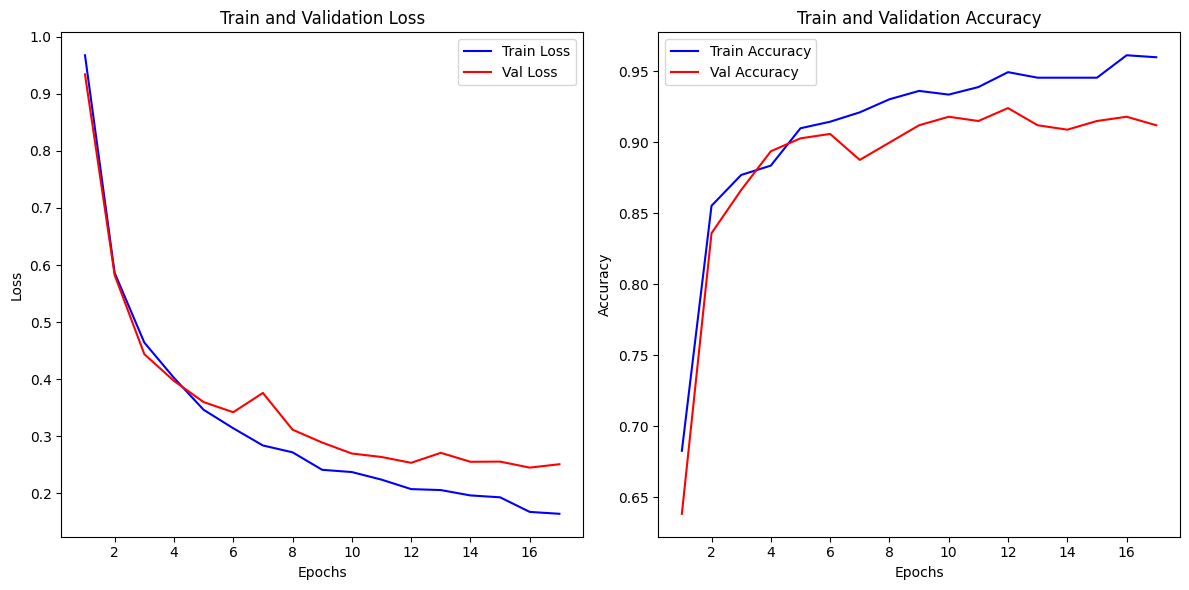

In [ ]:
import matplotlib.pyplot as plt

# Epoch data from the training logs
epochs = list(range(1, 18))  # 1 to 17 epochs (since early stopping happened at epoch 17)
train_loss = [0.9678, 0.5862, 0.4641, 0.4022, 0.3462, 0.3138, 0.2836, 0.2716, 0.2409, 0.2370,
              0.2237, 0.2071, 0.2054, 0.1960, 0.1927, 0.1671, 0.1638]
train_acc = [0.6827, 0.8552, 0.8769, 0.8835, 0.9098, 0.9144, 0.9210, 0.9302, 0.9361, 0.9335,
             0.9388, 0.9493, 0.9454, 0.9454, 0.9454, 0.9612, 0.9598]
val_loss = [0.9343, 0.5824, 0.4438, 0.3968, 0.3597, 0.3419, 0.3757, 0.3113, 0.2887, 0.2695,
            0.2634, 0.2532, 0.2707, 0.2550, 0.2553, 0.2448, 0.2507]
val_acc = [0.6383, 0.8359, 0.8663, 0.8936, 0.9027, 0.9058, 0.8875, 0.8997, 0.9119, 0.9179,
           0.9149, 0.9240, 0.9119, 0.9088, 0.9149, 0.9179, 0.9119]

# Plotting the Losses
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', color='blue')
plt.plot(epochs, val_loss, label='Val Loss', color='red')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy', color='blue')
plt.plot(epochs, val_acc, label='Val Accuracy', color='red')
plt.title('Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


## Load Pre-trained DenseNet Model

### Subtask:
Initialize a pre-trained DenseNet model from `torchvision.models` and modify its final classification layer to match the four brain tumor classes. Ensure that the initial layers are frozen, and only the new classifier will be trained.


**Reasoning**:
The subtask requires initializing a pre-trained DenseNet model, modifying its final classification layer, and freezing its initial layers. This code block will perform all these steps as instructed.



In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Load a pre-trained DenseNet model (e.g., densenet121)
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# 2. Freeze all parameters in the loaded DenseNet model
for param in densenet_model.parameters():
    param.requires_grad = False

# 3. Get the number of input features for the final classification layer
num_ftrs = densenet_model.classifier.in_features

# 4. Create a new final fully connected layer with 4 output classes
num_classes = len(train_dataset.classes) # Assuming train_dataset is already defined and contains class information
densenet_model.classifier = nn.Linear(num_ftrs, num_classes)

print(f"Pre-trained DenseNet model loaded and final layer modified for {num_classes} classes.")
print(f"Model's final classifier: {densenet_model.classifier}")

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


100%|██████████| 30.8M/30.8M [00:00<00:00, 83.3MB/s]


Pre-trained DenseNet model loaded and final layer modified for 4 classes.
Model's final classifier: Linear(in_features=1024, out_features=4, bias=True)


### Train ResNet model

In [ ]:
import torch.optim as optim

# 1. Move the densenet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(densenet_model.classifier.parameters(), lr=0.001)

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy = 0.0
best_model_wts = densenet_model.state_dict()
early_stopping_counter = 0

print(f"Starting DenseNet training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    densenet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    densenet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = densenet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nDenseNet training complete!")
print(f"Best DenseNet validation accuracy achieved: {best_val_accuracy:.4f}")

# Load best model weights into model
densenet_model.load_state_dict(best_model_wts)
print("Best DenseNet model weights loaded into densenet_model.")

Starting DenseNet training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 1.0171, Train Acc: 0.5971 | Val Loss: 0.7722, Val Acc: 0.7416
New best model saved with validation accuracy: 0.7416
Epoch 2/40 | Train Loss: 0.5786, Train Acc: 0.8302 | Val Loss: 0.5301, Val Acc: 0.8237
New best model saved with validation accuracy: 0.8237
Epoch 3/40 | Train Loss: 0.4711, Train Acc: 0.8565 | Val Loss: 0.4509, Val Acc: 0.8693
New best model saved with validation accuracy: 0.8693
Epoch 4/40 | Train Loss: 0.4379, Train Acc: 0.8585 | Val Loss: 0.3988, Val Acc: 0.8754
New best model saved with validation accuracy: 0.8754
Epoch 5/40 | Train Loss: 0.3714, Train Acc: 0.8815 | Val Loss: 0.3661, Val Acc: 0.8845
New best model saved with validation accuracy: 0.8845
Epoch 6/40 | Train Loss: 0.3276, Train Acc: 0.8953 | Val Loss: 0.3577, Val Acc: 0.8784
Early stopping counter: 1/5
Epoch 7/40 | Train Loss: 0.3078, Train Acc: 0.8999 | Val Loss: 0.3230, Val Acc: 0.9027
New best model saved with

### Evaluate ResNet model



In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. Set the densenet_model to evaluation mode
densenet_model.eval()

# 2. Initialize empty lists to store true labels and predicted labels for the test set
all_labels_densenet = []
all_predictions_densenet = []

# 3. Iterate through the test_loader, moving inputs and labels to the appropriate device
# 4. For each batch, get model outputs, convert them to predicted class labels, and append both true and predicted labels to their respective lists
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_densenet.extend(labels.cpu().numpy())
        all_predictions_densenet.extend(predicted.cpu().numpy())

# 5. Convert the lists of true and predicted labels into NumPy arrays
all_labels_densenet = np.array(all_labels_densenet)
all_predictions_densenet = np.array(all_predictions_densenet)

# 6. Calculate accuracy, precision, recall, and F1-score
accuracy_densenet = accuracy_score(all_labels_densenet, all_predictions_densenet)
precision_densenet = precision_score(all_labels_densenet, all_predictions_densenet, average='weighted')
recall_densenet = recall_score(all_labels_densenet, all_predictions_densenet, average='weighted')
f1_densenet = f1_score(all_labels_densenet, all_predictions_densenet, average='weighted')

# 7. Print the calculated evaluation metrics
print("\n--- DenseNet Model Evaluation on Test Data ---")
print(f"Accuracy: {accuracy_densenet:.4f}")
print(f"Precision: {precision_densenet:.4f}")
print(f"Recall: {recall_densenet:.4f}")
print(f"F1-Score: {f1_densenet:.4f}")


--- DenseNet Model Evaluation on Test Data ---
Accuracy: 0.9174
Precision: 0.9180
Recall: 0.9174
F1-Score: 0.9169


### Save ResNet model



In [ ]:
import os
import torch

# Define the path to save the model in Google Drive
save_path = '/content/drive/MyDrive/brain_tumor_object_detection/densenet_model.pth'

# Ensure the directory exists (optional, but good practice)
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(densenet_model.state_dict(), save_path)

print(f"Trained DenseNet model saved to: {save_path}")

Trained DenseNet model saved to: /content/drive/MyDrive/brain_tumor_object_detection/densenet_model.pth


###Plot ResNet Training Curves



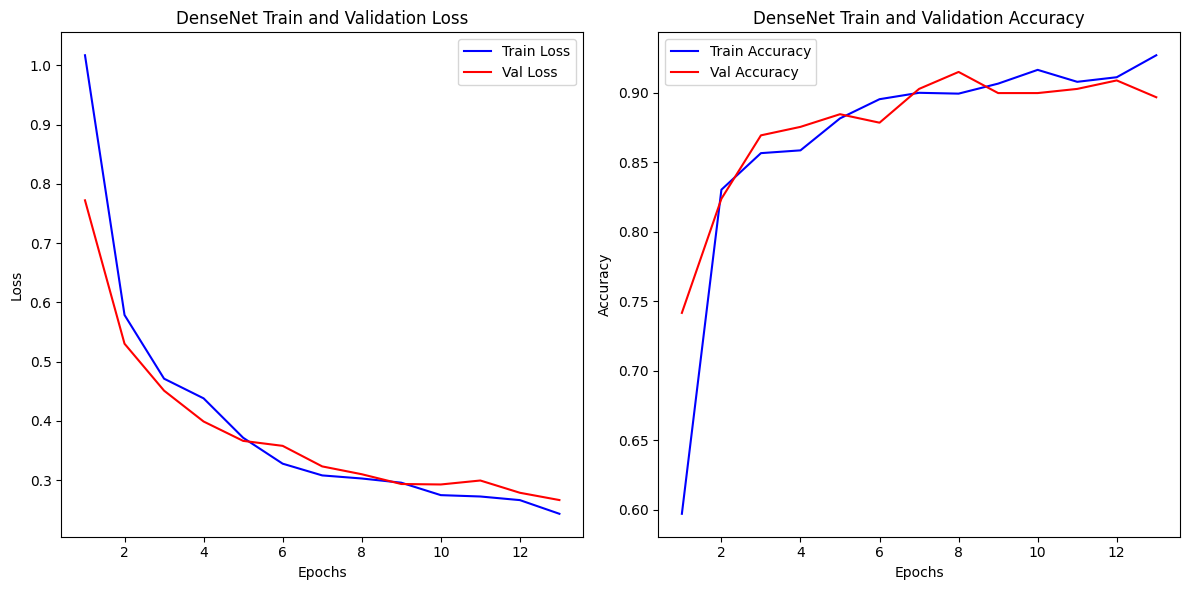

In [ ]:
import matplotlib.pyplot as plt

# Epoch data from the training logs for DenseNet
epochs_densenet = list(range(1, 14))  # 1 to 13 epochs (early stopping triggered at epoch 13)
train_loss_densenet = [1.0171, 0.5786, 0.4711, 0.4379, 0.3714, 0.3276, 0.3078, 0.3026, 0.2955, 0.2745, 0.2722, 0.2661, 0.2430]
train_acc_densenet = [0.5971, 0.8302, 0.8565, 0.8585, 0.8815, 0.8953, 0.8999, 0.8993, 0.9065, 0.9164, 0.9078, 0.9111, 0.9269]
val_loss_densenet = [0.7722, 0.5301, 0.4509, 0.3988, 0.3661, 0.3577, 0.3230, 0.3098, 0.2933, 0.2925, 0.2992, 0.2785, 0.2662]
val_acc_densenet = [0.7416, 0.8237, 0.8693, 0.8754, 0.8845, 0.8784, 0.9027, 0.9149, 0.8997, 0.8997, 0.9027, 0.9088, 0.8967]

# Plotting the Losses
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_densenet, train_loss_densenet, label='Train Loss', color='blue')
plt.plot(epochs_densenet, val_loss_densenet, label='Val Loss', color='red')
plt.title('DenseNet Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_densenet, train_acc_densenet, label='Train Accuracy', color='blue')
plt.plot(epochs_densenet, val_acc_densenet, label='Val Accuracy', color='red')
plt.title('DenseNet Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate DenseNet Model Class-wise Performance

### Subtask:
Calculate and display class-wise precision, recall, and F1-score for the DenseNet model on the test dataset. This will provide a detailed view of the model's performance for each specific brain tumor class.


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate class-wise precision, recall, and F1-score
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels_densenet, all_predictions_densenet, average=None, labels=np.arange(len(class_names)))

print("\n--- DenseNet Model Class-wise Evaluation on Test Data ---")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print("--------------------")


--- DenseNet Model Class-wise Evaluation on Test Data ---
Class: glioma
  Precision: 0.9841
  Recall: 0.9118
  F1-Score: 0.9466
--------------------
Class: meningioma
  Precision: 0.8734
  Recall: 0.8313
  F1-Score: 0.8519
--------------------
Class: notumor
  Precision: 0.9070
  Recall: 0.9398
  F1-Score: 0.9231
--------------------
Class: pituitary
  Precision: 0.9192
  Recall: 0.9785
  F1-Score: 0.9479
--------------------


## Visualize DenseNet Model Confusion Matrix

### Subtask:
Generate and display a confusion matrix for the DenseNet model's predictions on the test dataset. This will provide a detailed view of true positive, true negative, false positive, and false negative classifications for each brain tumor class.


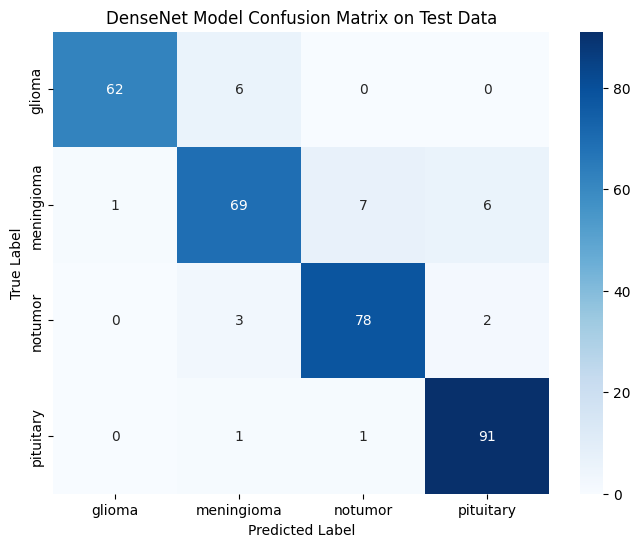

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate the confusion matrix
cm_densenet = confusion_matrix(all_labels_densenet, all_predictions_densenet)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('DenseNet Model Confusion Matrix on Test Data')
plt.show()

## Visualize XAI - Saliency Map - ResNet

### Subtask:
Generate and display a saliency map for a sample test image to visualize which pixels are most influential in the ResNet model's predictions.

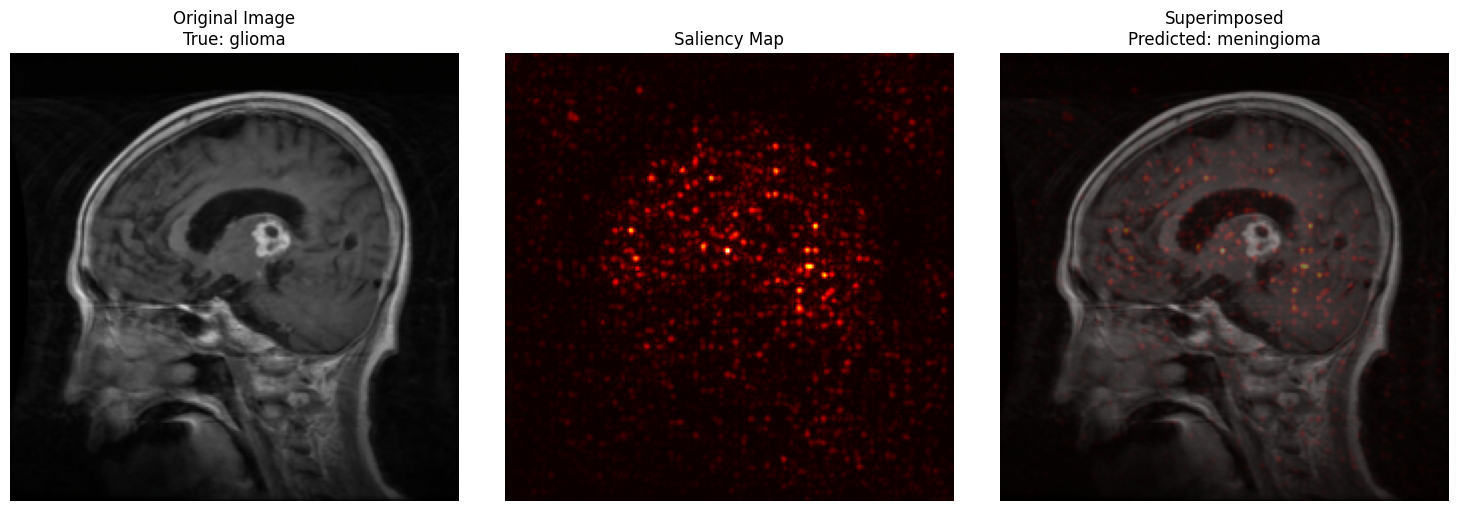

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# Assuming test_loader, device, and resnet_model are already defined

# Get a sample image from the test set
for img, label in test_loader:
    sample_image_tensor = img[0:1].to(device) # Take the first image of the batch
    original_image = img[0].cpu().numpy().transpose((1, 2, 0)) # For visualization
    true_label = label[0].item()
    break

# Unnormalize the image for display
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_image_display = std * original_image + mean
original_image_display = np.clip(original_image_display, 0, 1)

# Ensure the input image requires gradients
sample_image_tensor.requires_grad = True

# Perform a forward pass
resnet_model.eval()
output = resnet_model(sample_image_tensor)

# Get the predicted class
predicted_class_idx = output.argmax(dim=1).item()
predicted_score = output[0, predicted_class_idx]

# Perform backward pass to get gradients
resnet_model.zero_grad()
predicted_score.backward()

# Get the gradients with respect to the input image
saliency = sample_image_tensor.grad.data.abs().squeeze().cpu().numpy()

# Sum gradients across color channels (if desired) or take the max/mean
saliency = np.max(saliency, axis=0)

# Normalize saliency map for visualization
saliency /= saliency.max()

# Get class names
class_names = test_dataset.classes
true_class_name = class_names[true_label]
predicted_class_name = class_names[predicted_class_idx]

# Display results
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image_display)
plt.title(f'Original Image\nTrue: {true_class_name}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(1, 3, 3)
# Superimpose saliency map on original image
superimposed_saliency = original_image_display * 0.7 + plt.cm.hot(saliency)[..., :3] * 0.3 # Adjust weights as needed
superimposed_saliency = np.clip(superimposed_saliency, 0, 1)
plt.imshow(superimposed_saliency)
plt.title(f'Superimposed\nPredicted: {predicted_class_name}')
plt.axis('off')

plt.tight_layout()
plt.show()

# Task
Okay, I will proceed with generating and displaying Grad-CAM heatmaps for correctly classified and misclassified images from the ResNet model's predictions on the test dataset, and then summarize the insights.

First, I will identify a selection of correctly classified and misclassified images from the ResNet model's predictions.

## Visualize Correctly and Misclassified Images with Grad-CAM

### Subtask:
Identify a selection of correctly classified and misclassified images from the ResNet model's predictions for Grad-CAM visualization.


In [ ]:
correctly_classified_images = []
misclassified_images = []

# Function to remove all hooks from a module
def remove_all_hooks(model):
    for name, module in model.named_modules():
        if hasattr(module, '_forward_hooks'):
            module._forward_hooks.clear()
        if hasattr(module, '_backward_hooks'):
            module._backward_hooks.clear()

# Remove any lingering hooks from previous operations (e.g., saliency map generation)
remove_all_hooks(resnet_model)

# Set the model to evaluation mode
resnet_model.eval()

# Iterate through the test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        # Identify correctly classified images
        for i in range(len(labels)):
            if len(correctly_classified_images) < 4 and predicted[i] == labels[i]:
                correctly_classified_images.append({
                    'image_tensor': inputs[i].cpu(),
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

            # Identify misclassified images
            if len(misclassified_images) < 4 and predicted[i] != labels[i]:
                misclassified_images.append({
                    'image_tensor': inputs[i].cpu(),
                    'true_label': labels[i].item(),
                    'predicted_label': predicted[i].item()
                })

        if len(correctly_classified_images) >= 4 and len(misclassified_images) >= 4:
            break # Stop once we have enough samples

print(f"Found {len(correctly_classified_images)} correctly classified images.")
print(f"Found {len(misclassified_images)} misclassified images.")

Found 4 correctly classified images.
Found 4 misclassified images.


## ResNet Model Parameters

### Subtask:
Display the key parameters of the trained ResNet model, focusing on the configuration of its final classification layer.

In [ ]:
# Display the number of input features to the final layer
print(f"Number of input features to the final layer (num_ftrs): {resnet_model.fc.in_features}")

# Display the number of output classes
print(f"Number of output classes (num_classes): {num_classes}")

# Display the entire final layer structure
print(f"Model's final layer (resnet_model.fc):\n{resnet_model.fc}")

Number of input features to the final layer (num_ftrs): 2048
Number of output classes (num_classes): 4
Model's final layer (resnet_model.fc):
Linear(in_features=2048, out_features=4, bias=True)


## Generate and Display Grad-CAM Heatmaps

### Subtask:
Generate and display Grad-CAM heatmaps for the selected correctly classified and misclassified images using the ResNet model. This will visually highlight regions of input images that were most influential in the model's predictions.


Generating Grad-CAM heatmaps using target layer: layer4.2.conv3


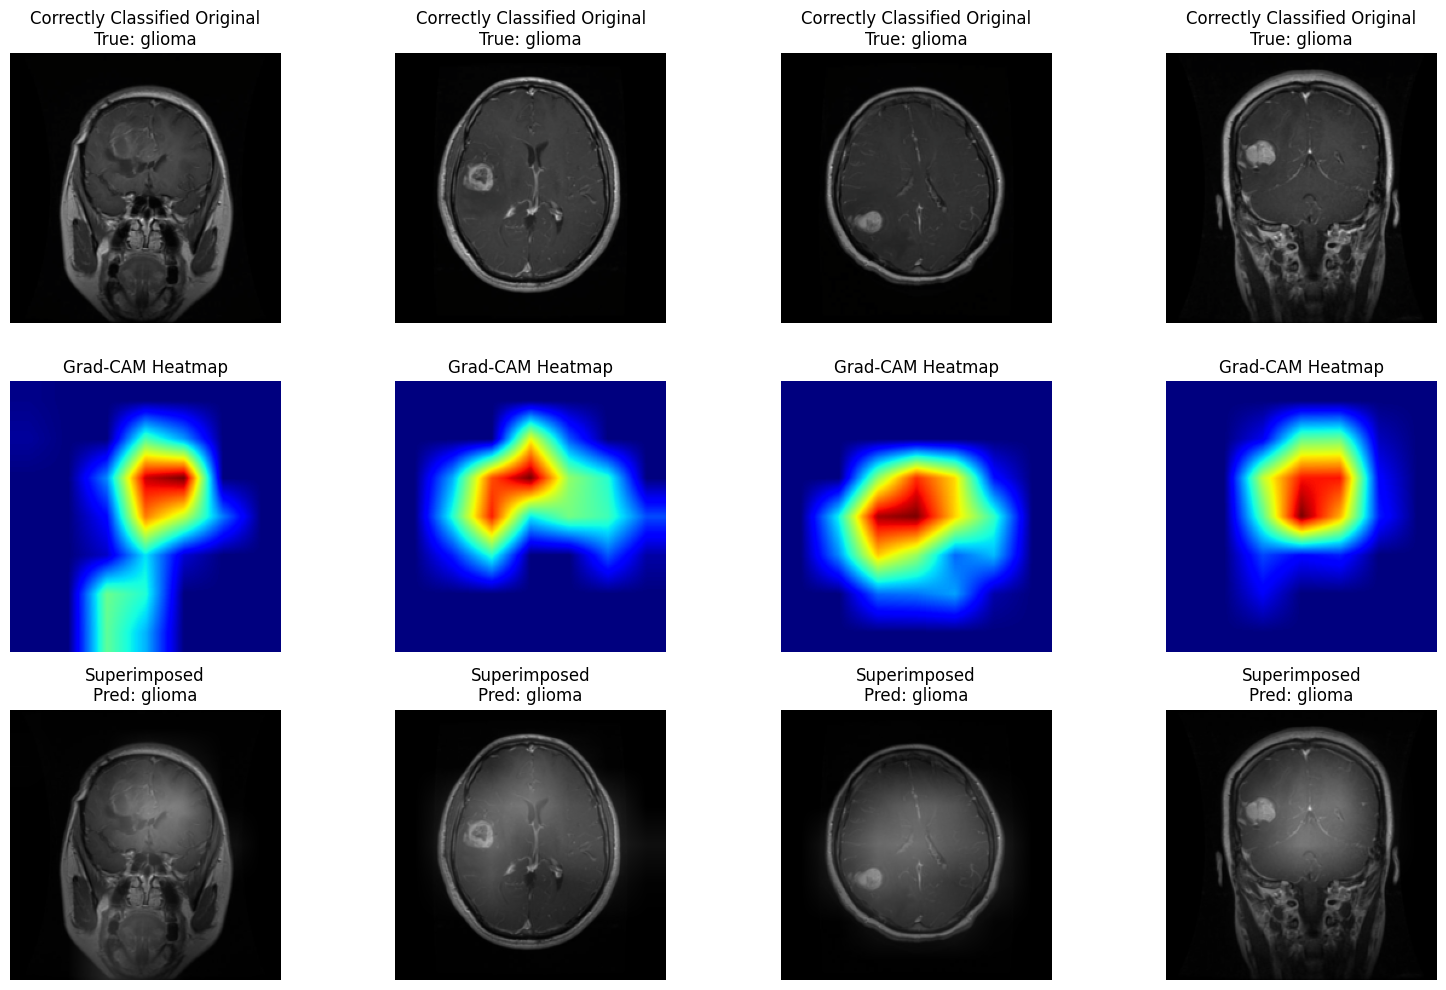

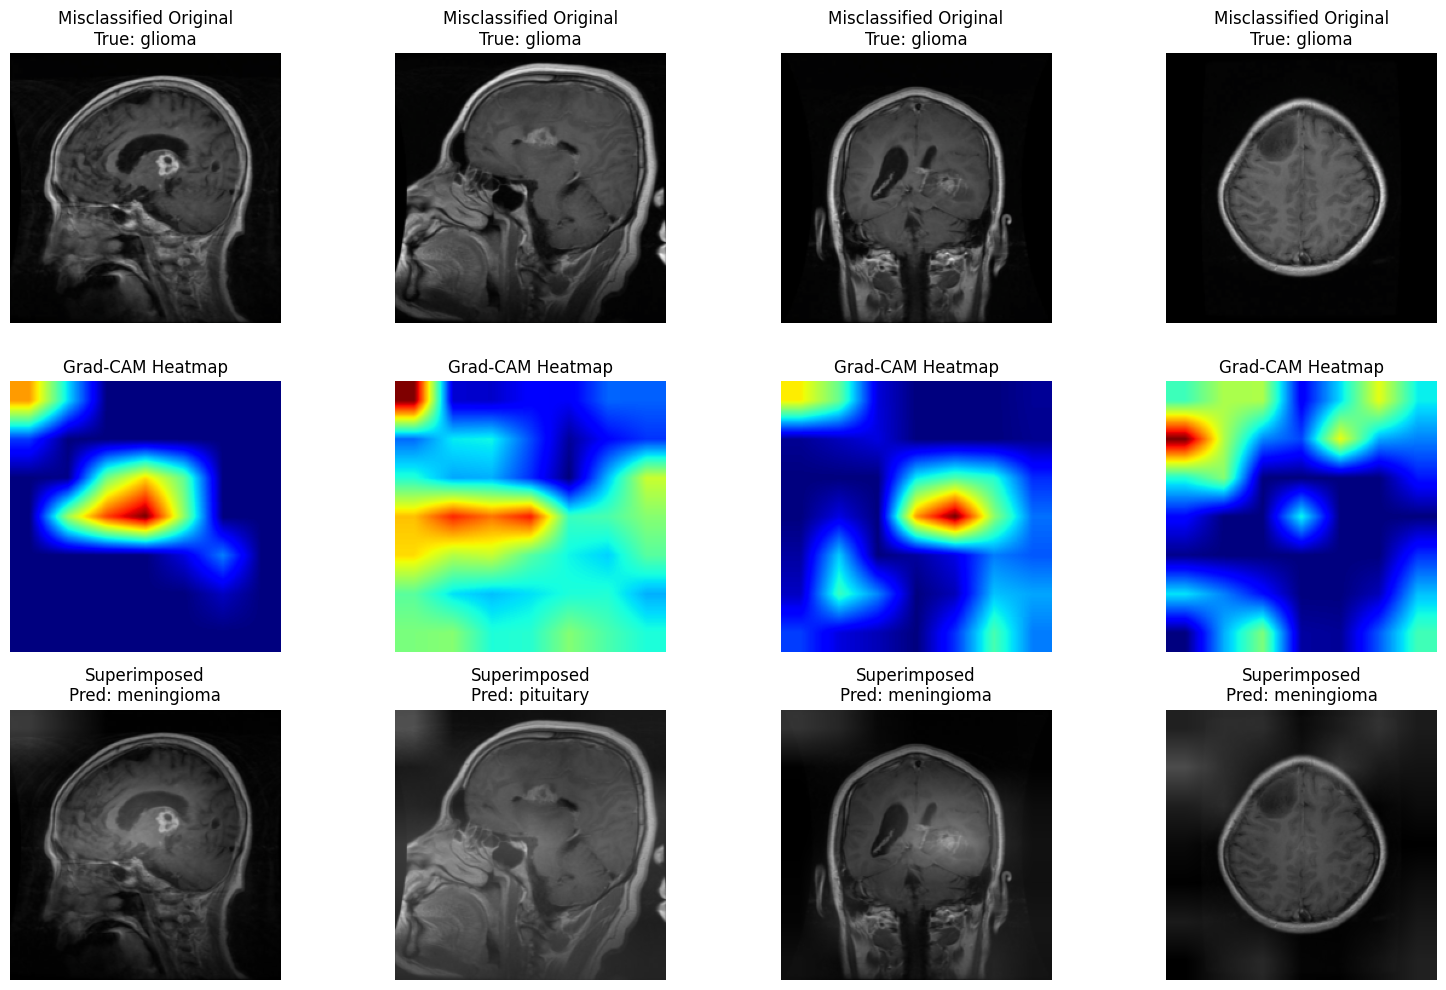

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Define GradCAM class ---
class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = None
        self.gradients = None
        self.activations = None
        self.model.eval()

        # Register hooks
        for name, module in self.model.named_modules():
            if name == target_layer_name:
                self.target_layer = module
                self.target_layer.register_forward_hook(self._save_activation)
                self.target_layer.register_full_backward_hook(self._save_gradient)
                break

        if self.target_layer is None:
            raise ValueError(f"Target layer '{target_layer_name}' not found in the model.")

    def _save_activation(self, module, input, output):
        self.activations = output

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_category=None):
        self.model.zero_grad()

        # Forward pass
        output = self.model(input_tensor)

        if target_category is None:
            target_category = output.argmax(dim=1).item()

        # Backward pass
        one_hot = torch.zeros_like(output).to(input_tensor.device)
        one_hot[0][target_category] = 1
        output.backward(gradient=one_hot, retain_graph=True)

        # Get gradients and activations
        gradients = self.gradients.cpu().data.numpy()[0]
        activations = self.activations.cpu().data.numpy()[0]

        # Compute weights (global average pooling of gradients)
        weights = np.mean(gradients, axis=(1, 2))

        # Build heatmap
        heatmap = np.zeros(activations.shape[1:], dtype=np.float32)
        for i, w in enumerate(weights):
            heatmap += w * activations[i]

        # Apply ReLU
        heatmap = np.maximum(heatmap, 0)

        # Normalize heatmap
        if np.max(heatmap) > 0:
            heatmap = heatmap / np.max(heatmap)

        # Resize heatmap to input image size
        heatmap = F.interpolate(torch.from_numpy(heatmap).unsqueeze(0).unsqueeze(0),
                                size=input_tensor.shape[2:],
                                mode='bilinear',
                                align_corners=False).squeeze().cpu().numpy()

        return heatmap

# --- 2. Define utility function to preprocess and unnormalize images ---
def preprocess_and_unnormalize_image(image_tensor):
    # Unnormalize image for display
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    # Convert tensor to numpy array (C, H, W) and then to (H, W, C)
    image_np = image_tensor.numpy().transpose((1, 2, 0))

    # Unnormalize
    image_display = std * image_np + mean
    image_display = np.clip(image_display, 0, 1)
    return image_display

# --- 3. Grad-CAM Visualization ---
class_names = train_dataset.classes # Assuming train_dataset is available

# Target layer for ResNet50. Often, the last convolutional layer before the pooling and FC layers.
# For ResNet50, 'layer4' is typically the last block of convolutional layers.
# We can choose the last conv layer in layer4, e.g., 'layer4.2.conv3'
# Or for a broader view of features from the entire last block, we can use 'layer4'

# Option 1: Last convolutional layer in the last block
target_layer_name = 'layer4.2.conv3'
# Option 2: The entire last block (feature maps from the output of the entire block)
# target_layer_name = 'layer4'

# Initialize GradCAM
grad_cam = GradCAM(resnet_model, target_layer_name=target_layer_name)

print(f"Generating Grad-CAM heatmaps using target layer: {target_layer_name}")

def display_gradcam_results(images_list, title_prefix="", num_images=4):
    plt.figure(figsize=(num_images * 4, 10))
    for i, img_info in enumerate(images_list):
        if i >= num_images: break

        image_tensor = img_info['image_tensor'].unsqueeze(0).to(device).requires_grad_(True)
        true_label = img_info['true_label']
        predicted_label = img_info['predicted_label']

        # Generate Grad-CAM heatmap for the predicted class
        heatmap = grad_cam(image_tensor, target_category=predicted_label)

        # Unnormalize image for display
        image_display = preprocess_and_unnormalize_image(img_info['image_tensor'])

        # Superimpose heatmap
        heatmap_resized = np.stack([heatmap, heatmap, heatmap], axis=-1) # Convert to 3 channels
        superimposed_img = image_display * 0.7 + heatmap_resized * 0.3 # Adjust blend weights
        superimposed_img = np.clip(superimposed_img, 0, 1) # Ensure values are within valid range

        # Plot original image
        plt.subplot(3, num_images, i + 1)
        plt.imshow(image_display)
        plt.title(f'{title_prefix} Original\nTrue: {class_names[true_label]}')
        plt.axis('off')

        # Plot heatmap
        plt.subplot(3, num_images, i + num_images + 1)
        plt.imshow(heatmap, cmap='jet')
        plt.title('Grad-CAM Heatmap')
        plt.axis('off')

        # Plot superimposed image
        plt.subplot(3, num_images, i + 2 * num_images + 1)
        plt.imshow(superimposed_img)
        plt.title(f'Superimposed\nPred: {class_names[predicted_label]}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Display Grad-CAM for correctly classified images
display_gradcam_results(correctly_classified_images, title_prefix="Correctly Classified", num_images=min(4, len(correctly_classified_images)))

# Display Grad-CAM for misclassified images
display_gradcam_results(misclassified_images, title_prefix="Misclassified", num_images=min(4, len(misclassified_images)))

## Prepare Dataset for CNN Training

### Subtask:
Load the brain tumor dataset, define data transformations suitable for a CNN (resizing, converting to tensor, and normalizing), and create PyTorch DataLoader instances for the training, validation, and test sets. This will leverage the dataset structure defined in `brain_tumor_dataset.yaml`.


In [ ]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# 1. Define image transformations for CNN
# Resizing images to 224x224 pixels, converting to PyTorch tensors,
# and normalizing with ImageNet mean and std values.
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2. Define paths to the dataset directories
base_path = '/content/drive/MyDrive/brain_tumor_object_detection/data/Brain Tumor labeled dataset/'
train_dir = base_path + 'train'
val_dir = base_path + 'val'
test_dir = base_path + 'test'

# 3. Create ImageFolder datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
val_dataset = ImageFolder(root=val_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# 4. Create DataLoader instances
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

print("Dataset preparation complete: train_loader, val_loader, and test_loader created.")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")
print(f"Number of test samples: {len(test_dataset)}")
print(f"Classes: {train_dataset.classes}")

Dataset preparation complete: train_loader, val_loader, and test_loader created.
Number of training samples: 1519
Number of validation samples: 327
Number of test samples: 329
Classes: ['glioma', 'meningioma', 'notumor', 'pituitary']


## Define CNN Model from Scratch

### Subtask:
Define the architecture of a Convolutional Neural Network (CNN) from scratch, including convolutional layers, pooling layers, and fully connected layers, to classify the four brain tumor classes: 'glioma', 'meningioma', 'notumor', and 'pituitary'.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# 1. Define a Python class for your CNN model that inherits from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Calculate the flattened size after convolutional and pooling layers
        # Assuming input image size is 224x224 (from previous transforms)
        # 224 -> 112 (pool1) -> 56 (pool2) -> 28 (pool3)
        self.fc1 = nn.Linear(64 * 28 * 28, 512) # 64 channels * 28x28 feature map
        self.fc2 = nn.Linear(512, 4) # 4 output classes

    def forward(self, x):
        # Pass through Conv Block 1
        x = self.pool1(F.relu(self.conv1(x)))
        # Pass through Conv Block 2
        x = self.pool2(F.relu(self.conv2(x)))
        # Pass through Conv Block 3
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 28 * 28) # -1 infers batch size

        # Pass through Fully Connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# 5. Instantiate your CNN model and print its architecture
cnn_model = SimpleCNN()
print(cnn_model)


SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=4, bias=True)
)


## Train CNN Model

### Subtask:
Set up the training parameters including the loss function (e.g., CrossEntropyLoss), an optimizer (e.g., Adam), and the number of epochs. Train the CNN model using the prepared training and validation data.


In [ ]:
import torch.optim as optim

# 1. Move the cnn_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cnn_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer for all trainable parameters of the cnn_model
optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy = 0.0
best_model_wts = cnn_model.state_dict()
early_stopping_counter = 0

print(f"Starting CNN training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    cnn_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = cnn_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # f. Evaluate the model on the val_loader
    cnn_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = cnn_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # h. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # i. Implement early stopping logic
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = cnn_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        # j. If the early_stopping_counter exceeds patience, break the training loop.
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nCNN Training complete!")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")

# 7. Load best model weights into cnn_model
cnn_model.load_state_dict(best_model_wts)
print("Best CNN model weights loaded into cnn_model.")

Starting CNN training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 1.0991, Train Acc: 0.6307 | Val Loss: 0.6007, Val Acc: 0.7568
New best model saved with validation accuracy: 0.7568
Epoch 2/40 | Train Loss: 0.4230, Train Acc: 0.8479 | Val Loss: 0.4773, Val Acc: 0.8298
New best model saved with validation accuracy: 0.8298
Epoch 3/40 | Train Loss: 0.2846, Train Acc: 0.8953 | Val Loss: 0.5032, Val Acc: 0.8632
New best model saved with validation accuracy: 0.8632
Epoch 4/40 | Train Loss: 0.1627, Train Acc: 0.9414 | Val Loss: 0.4459, Val Acc: 0.8967
New best model saved with validation accuracy: 0.8967
Epoch 5/40 | Train Loss: 0.0755, Train Acc: 0.9756 | Val Loss: 0.5540, Val Acc: 0.8693
Early stopping counter: 1/5
Epoch 6/40 | Train Loss: 0.0336, Train Acc: 0.9914 | Val Loss: 0.3890, Val Acc: 0.8997
New best model saved with validation accuracy: 0.8997
Epoch 7/40 | Train Loss: 0.0147, Train Acc: 0.9954 | Val Loss: 0.5420, Val Acc: 0.8967
Early stopping counter: 1/5
Ep

## Evaluate CNN Model

### Subtask:
Evaluate the performance of the trained CNN model on the test dataset using metrics such as accuracy, precision, recall, and F1-score.


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np

# 1. Set the cnn_model to evaluation mode
cnn_model.eval()

# 2. Initialize empty lists to store true labels and predicted labels for the test set
all_labels_cnn = []
all_predictions_cnn = []

# 3. Iterate through the test_loader, moving inputs and labels to the appropriate device
# 4. For each batch, get model outputs, convert them to predicted class labels, and append both true and predicted labels to their respective lists
with torch.no_grad(): # Disable gradient calculation for evaluation
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        all_labels_cnn.extend(labels.cpu().numpy())
        all_predictions_cnn.extend(predicted.cpu().numpy())

# 5. Convert the lists of true and predicted labels into NumPy arrays
all_labels_cnn = np.array(all_labels_cnn)
all_predictions_cnn = np.array(all_predictions_cnn)

# 6. Calculate accuracy, precision, recall, and F1-score
accuracy_cnn = accuracy_score(all_labels_cnn, all_predictions_cnn)
precision_cnn = precision_score(all_labels_cnn, all_predictions_cnn, average='weighted')
recall_cnn = recall_score(all_labels_cnn, all_predictions_cnn, average='weighted')
f1_cnn = f1_score(all_labels_cnn, all_predictions_cnn, average='weighted')

# 7. Print the calculated evaluation metrics
print("\n--- CNN Model Evaluation on Test Data ---")
print(f"Accuracy: {accuracy_cnn:.4f}")
print(f"Precision: {precision_cnn:.4f}")
print(f"Recall: {recall_cnn:.4f}")
print(f"F1-Score: {f1_cnn:.4f}")


--- CNN Model Evaluation on Test Data ---
Accuracy: 0.9144
Precision: 0.9143
Recall: 0.9144
F1-Score: 0.9138


## Save Trained CNN Model

### Subtask:
Save the trained CNN model's state dictionary to your Google Drive for future use.


In [ ]:
import os
import torch

# 1. Define the full path where you want to save the model's state dictionary in your Google Drive
save_path_cnn = '/content/drive/MyDrive/brain_tumor_object_detection/cnn_model.pth'

# 2. Ensure the directory for the save path exists using os.makedirs() with exist_ok=True
os.makedirs(os.path.dirname(save_path_cnn), exist_ok=True)

# 3. Save the cnn_model's state dictionary to the specified path using torch.save()
torch.save(cnn_model.state_dict(), save_path_cnn)

# 4. Print a confirmation message indicating the save path
print(f"Trained CNN model saved to: {save_path_cnn}")

Trained CNN model saved to: /content/drive/MyDrive/brain_tumor_object_detection/cnn_model.pth


## Visualize Training and Validation Curves

### Subtask:
Generate and display plots for training/validation loss and training/validation accuracy to visualize the CNN model's learning progress over epochs.


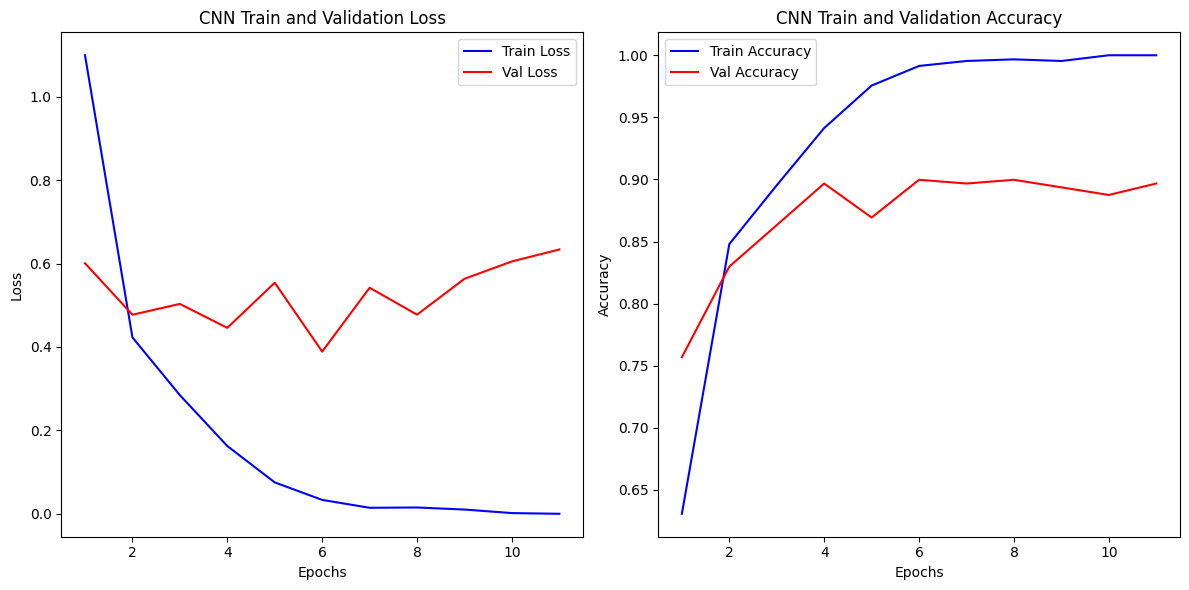

In [ ]:
import matplotlib.pyplot as plt

# Epoch data from the training logs for CNN
epochs_cnn = list(range(1, 12))  # 1 to 11 epochs (early stopping triggered at epoch 11)
train_loss_cnn = [1.0991, 0.4230, 0.2846, 0.1627, 0.0755, 0.0336, 0.0147, 0.0154, 0.0105, 0.0020, 0.0003]
train_acc_cnn = [0.6307, 0.8479, 0.8953, 0.9414, 0.9756, 0.9914, 0.9954, 0.9967, 0.9954, 1.0000, 1.0000]
val_loss_cnn = [0.6007, 0.4773, 0.5032, 0.4459, 0.5540, 0.3890, 0.5420, 0.4775, 0.5635, 0.6051, 0.6337]
val_acc_cnn = [0.7568, 0.8298, 0.8632, 0.8967, 0.8693, 0.8997, 0.8967, 0.8997, 0.8936, 0.8875, 0.8967]

# Plotting the Losses
plt.figure(figsize=(12, 6))

# Plot train and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs_cnn, train_loss_cnn, label='Train Loss', color='blue')
plt.plot(epochs_cnn, val_loss_cnn, label='Val Loss', color='red')
plt.title('CNN Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot train and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_cnn, train_acc_cnn, label='Train Accuracy', color='blue')
plt.plot(epochs_cnn, val_acc_cnn, label='Val Accuracy', color='red')
plt.title('CNN Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

## Evaluate CNN Model Class-wise Performance

### Subtask:
Calculate and display class-wise precision, recall, and F1-score for the CNN model on the test dataset. This will provide a detailed view of the model's performance for each specific brain tumor class.


In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate class-wise precision, recall, and F1-score
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(all_labels_cnn, all_predictions_cnn, average=None, labels=np.arange(len(class_names)))

# Print a header for the class-wise evaluation
print("\n--- CNN Model Class-wise Evaluation on Test Data ---")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print("--------------------")


--- CNN Model Class-wise Evaluation on Test Data ---
Class: glioma
  Precision: 0.9375
  Recall: 0.8824
  F1-Score: 0.9091
--------------------
Class: meningioma
  Precision: 0.8861
  Recall: 0.8434
  F1-Score: 0.8642
--------------------
Class: notumor
  Precision: 0.8736
  Recall: 0.9157
  F1-Score: 0.8941
--------------------
Class: pituitary
  Precision: 0.9588
  Recall: 1.0000
  F1-Score: 0.9789
--------------------


## Visualize CNN Model Confusion Matrix

### Subtask:
Generate and display a confusion matrix for the CNN model's predictions on the test dataset. This will provide a detailed view of true positive, true negative, false positive, and false negative classifications for each brain tumor class.


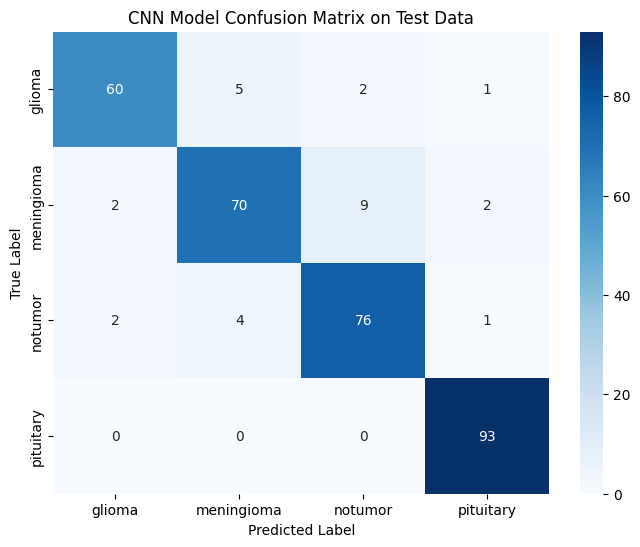

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate the confusion matrix
cm_cnn = confusion_matrix(all_labels_cnn, all_predictions_cnn)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_cnn, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Model Confusion Matrix on Test Data')
plt.show()

## Final Task

### Subtask:
Summarize the training and evaluation results of the CNN model and highlight its performance metrics.


## Load Pre-trained EfficientNet Model

### Subtask:
Initialize a pre-trained EfficientNet model from `torchvision.models` and modify its final classification layer to match the four brain tumor classes. The initial layers will be frozen, and only the new classifier will be trained.


In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# 1. Load a pre-trained EfficientNet model (e.g., efficientnet_b0)
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# 2. Freeze all parameters in the loaded EfficientNet model
for param in efficientnet_model.parameters():
    param.requires_grad = False

# 3. Get the number of input features for the final classification layer
num_ftrs = efficientnet_model.classifier[1].in_features

# 4. Create a new final fully connected layer with 4 output classes
num_classes = len(train_dataset.classes) # Assuming train_dataset is already defined and contains class information
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs, num_classes)
)

print(f"Pre-trained EfficientNet model loaded and final layer modified for {num_classes} classes.")
print(f"Model's final classifier: {efficientnet_model.classifier}")

Pre-trained EfficientNet model loaded and final layer modified for 4 classes.
Model's final classifier: Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=4, bias=True)
)


## Train EfficientNet Model

### Subtask:
Set up the training parameters including the loss function (e.g., CrossEntropyLoss), an optimizer (e.g., Adam), and the number of epochs. Train the EfficientNet model using the prepared training and validation data.

In [ ]:
import torch.optim as optim

# 1. Move the efficientnet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(efficientnet_model.classifier.parameters(), lr=0.001)

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy = 0.0
best_model_wts = efficientnet_model.state_dict()
early_stopping_counter = 0

print(f"Starting EfficientNet training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    efficientnet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    efficientnet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f}")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = efficientnet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nEfficientNet training complete!")
print(f"Best EfficientNet validation accuracy achieved: {best_val_accuracy:.4f}")

# Load best model weights into model
efficientnet_model.load_state_dict(best_model_wts)
print("Best EfficientNet model weights loaded into efficientnet_model.")

Starting EfficientNet training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 0.8738, Train Acc: 0.7024 | Val Loss: 0.5940, Val Acc: 0.8593
New best model saved with validation accuracy: 0.8593
Epoch 2/40 | Train Loss: 0.5037, Train Acc: 0.8486 | Val Loss: 0.3820, Val Acc: 0.8991
New best model saved with validation accuracy: 0.8991
Epoch 3/40 | Train Loss: 0.4319, Train Acc: 0.8716 | Val Loss: 0.3566, Val Acc: 0.9052
New best model saved with validation accuracy: 0.9052
Epoch 4/40 | Train Loss: 0.3684, Train Acc: 0.8802 | Val Loss: 0.3081, Val Acc: 0.9144
New best model saved with validation accuracy: 0.9144
Epoch 5/40 | Train Loss: 0.3334, Train Acc: 0.8927 | Val Loss: 0.2912, Val Acc: 0.9083
Early stopping counter: 1/5
Epoch 6/40 | Train Loss: 0.3033, Train Acc: 0.9006 | Val Loss: 0.2788, Val Acc: 0.9205
New best model saved with validation accuracy: 0.9205
Epoch 7/40 | Train Loss: 0.3157, Train Acc: 0.8881 | Val Loss: 0.2742, Val Acc: 0.9205
Early stopping counte

###Evaluate EfficientNet

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch

# 1. Set model to evaluation mode
efficientnet_model.eval()

# 2. Lists to collect predictions and labels
all_labels_efficientnet = []
all_predictions_efficientnet = []

# 3. Loop through test_loader
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = efficientnet_model(inputs)

        # Get predicted classes
        _, predicted = torch.max(outputs.data, 1)

        all_labels_efficientnet.extend(labels.cpu().numpy())
        all_predictions_efficientnet.extend(predicted.cpu().numpy())

# 4. Convert to numpy arrays
all_labels_efficientnet = np.array(all_labels_efficientnet)
all_predictions_efficientnet = np.array(all_predictions_efficientnet)

# 5. Compute metrics (weighted for multi-class tasks)
accuracy_efficientnet = accuracy_score(all_labels_efficientnet, all_predictions_efficientnet)
precision_efficientnet = precision_score(all_labels_efficientnet, all_predictions_efficientnet, average='weighted')
recall_efficientnet = recall_score(all_labels_efficientnet, all_predictions_efficientnet, average='weighted')
f1_efficientnet = f1_score(all_labels_efficientnet, all_predictions_efficientnet, average='weighted')

# 6. Print results
print("\n--- EfficientNet Model Evaluation on Test Data ---")
print(f"Accuracy: {accuracy_efficientnet:.4f}")
print(f"Precision (weighted): {precision_efficientnet:.4f}")
print(f"Recall (weighted): {recall_efficientnet:.4f}")
print(f"F1-Score (weighted): {f1_efficientnet:.4f}")



--- EfficientNet Model Evaluation on Test Data ---
Accuracy: 0.9271
Precision (weighted): 0.9271
Recall (weighted): 0.9271
F1-Score (weighted): 0.9264


### Save EfficientNet

In [ ]:
import os
import torch

# Define the path to save the EfficientNet model
save_path = '/content/drive/MyDrive/brain_tumor_object_detection/efficientnet_model.pth'

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save model weights
torch.save(efficientnet_model.state_dict(), save_path)

print(f"Trained EfficientNet model saved to: {save_path}")


Trained EfficientNet model saved to: /content/drive/MyDrive/brain_tumor_object_detection/efficientnet_model.pth


### Evaluate EffientNet class wise performance

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

# Get class names from the dataset
class_names = train_dataset.classes

# Calculate per-class precision, recall, F1
precision_per_class, recall_per_class, f1_per_class, _ = precision_recall_fscore_support(
    all_labels_efficientnet,
    all_predictions_efficientnet,
    average=None,
    labels=np.arange(len(class_names))
)

print("\n--- EfficientNet Model Class-wise Evaluation on Test Data ---")
for i, class_name in enumerate(class_names):
    print(f"Class: {class_name}")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1-Score: {f1_per_class[i]:.4f}")
    print("--------------------")



--- EfficientNet Model Class-wise Evaluation on Test Data ---
Class: glioma
  Precision: 0.9692
  Recall: 0.9130
  F1-Score: 0.9403
--------------------
Class: meningioma
  Precision: 0.8846
  Recall: 0.8313
  F1-Score: 0.8571
--------------------
Class: notumor
  Precision: 0.8989
  Recall: 0.9639
  F1-Score: 0.9302
--------------------
Class: pituitary
  Precision: 0.9588
  Recall: 0.9894
  F1-Score: 0.9738
--------------------


### EfficientNet Confusion Maatrix

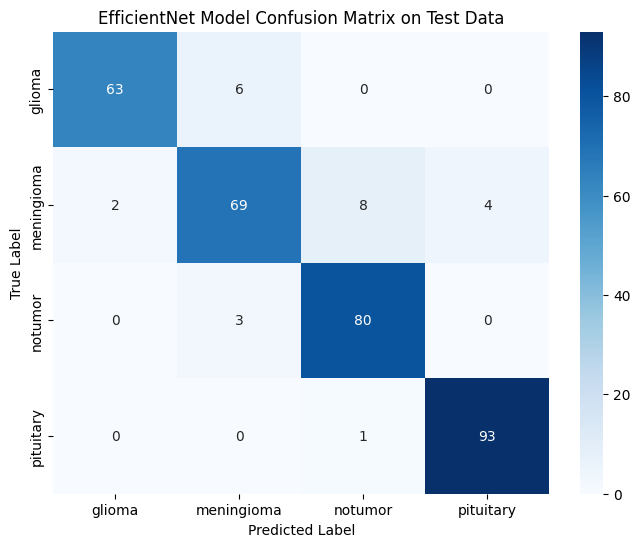

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Get class names
class_names = train_dataset.classes

# Compute confusion matrix
cm_efficientnet = confusion_matrix(all_labels_efficientnet, all_predictions_efficientnet)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_efficientnet, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('EfficientNet Model Confusion Matrix on Test Data')
plt.show()


###EfficientNet Training Curves

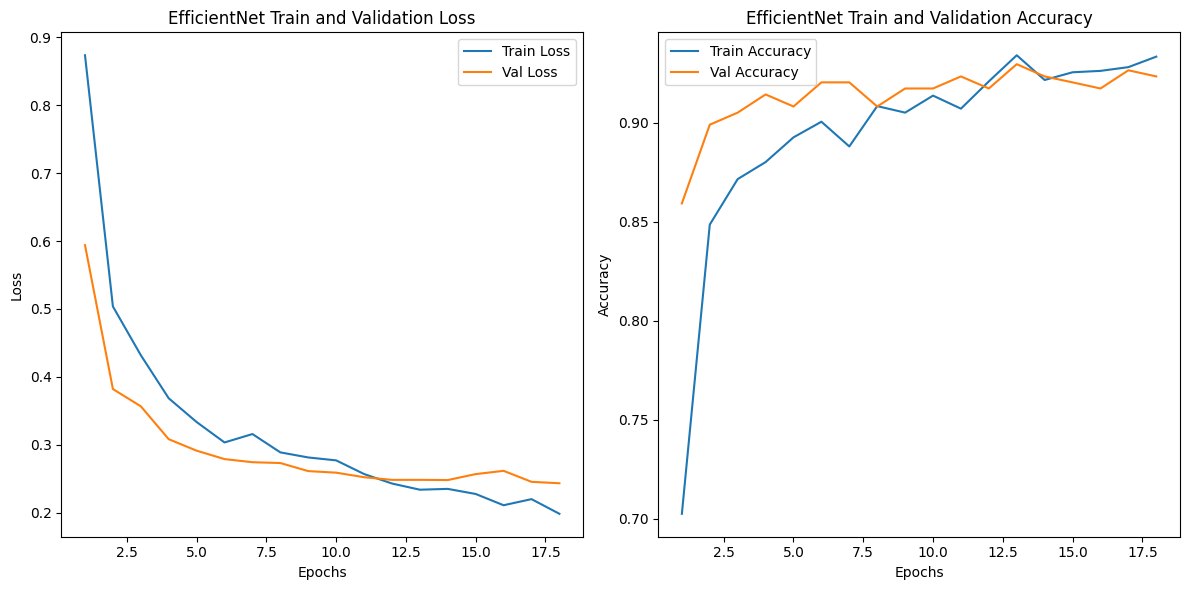

In [ ]:
import matplotlib.pyplot as plt

# ============================
# EfficientNet Training History (Extracted from your logs)
# ============================

epochs_eff = list(range(1, 19))  # Training stopped at epoch 18

train_loss_efficientnet = [
    0.8738, 0.5037, 0.4319, 0.3684, 0.3334, 0.3033,
    0.3157, 0.2887, 0.2812, 0.2769, 0.2568, 0.2428,
    0.2337, 0.2349, 0.2274, 0.2108, 0.2198, 0.1982
]

val_loss_efficientnet = [
    0.5940, 0.3820, 0.3566, 0.3081, 0.2912, 0.2788,
    0.2742, 0.2730, 0.2611, 0.2588, 0.2521, 0.2482,
    0.2482, 0.2479, 0.2567, 0.2615, 0.2453, 0.2432
]

train_acc_efficientnet = [
    0.7024, 0.8486, 0.8716, 0.8802, 0.8927, 0.9006,
    0.8881, 0.9085, 0.9052, 0.9138, 0.9072, 0.9210,
    0.9342, 0.9217, 0.9256, 0.9263, 0.9282, 0.9335
]

val_acc_efficientnet = [
    0.8593, 0.8991, 0.9052, 0.9144, 0.9083, 0.9205,
    0.9205, 0.9083, 0.9174, 0.9174, 0.9235, 0.9174,
    0.9297, 0.9235, 0.9205, 0.9174, 0.9266, 0.9235
]

# ============================
# Plot the curves
# ============================

plt.figure(figsize=(12, 6))

# ------ LOSS PLOT ------
plt.subplot(1, 2, 1)
plt.plot(epochs_eff, train_loss_efficientnet, label='Train Loss')
plt.plot(epochs_eff, val_loss_efficientnet, label='Val Loss')
plt.title('EfficientNet Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# ------ ACCURACY PLOT ------
plt.subplot(1, 2, 2)
plt.plot(epochs_eff, train_acc_efficientnet, label='Train Accuracy')
plt.plot(epochs_eff, val_acc_efficientnet, label='Val Accuracy')
plt.title('EfficientNet Train and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


### EfficientNet XAI

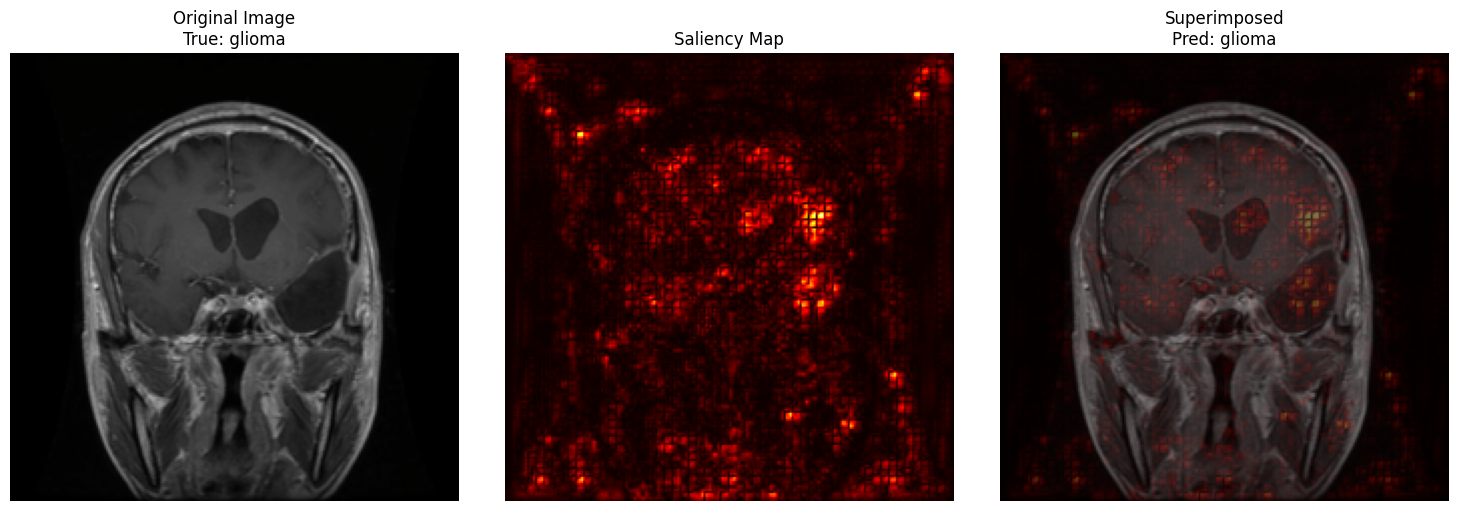

Correct: 4
Misclassified: 4


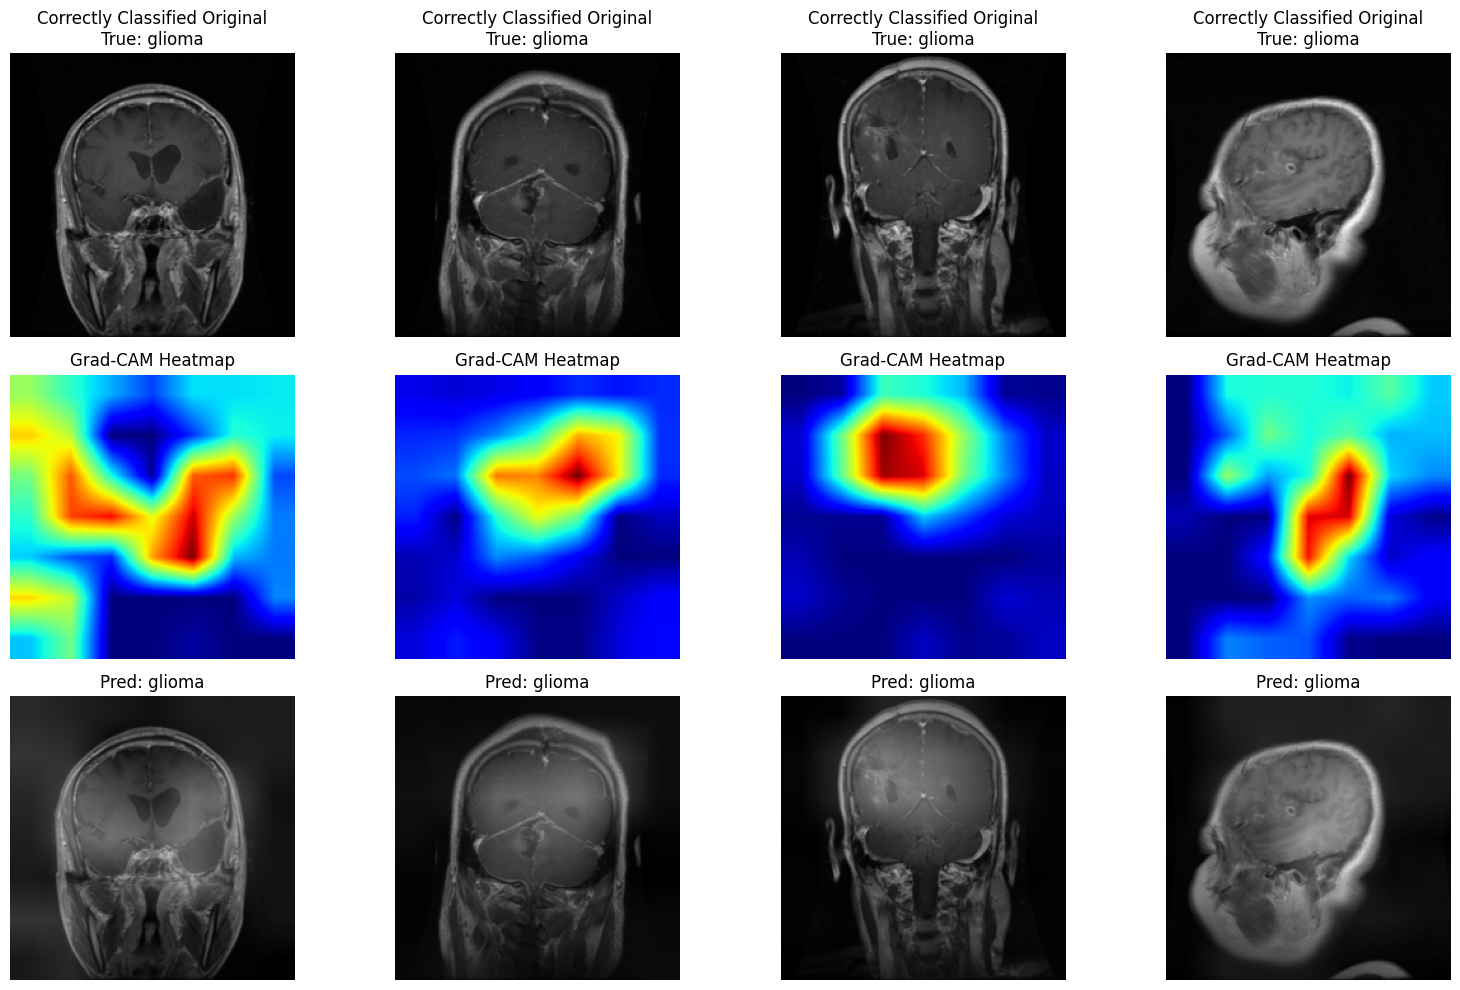

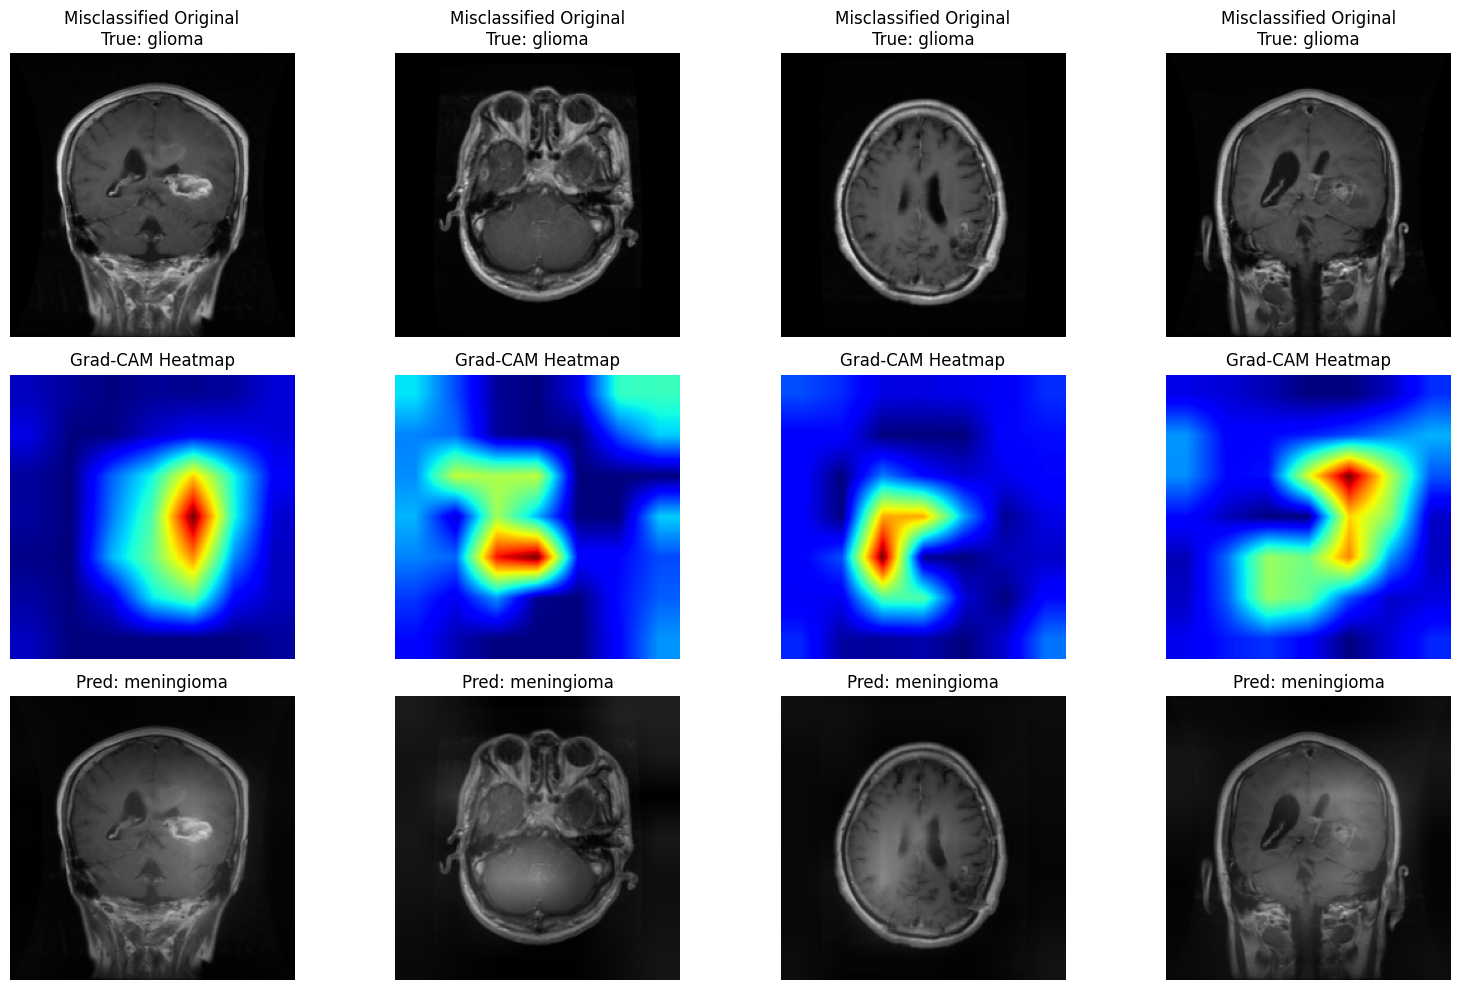

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


# -----------------------------------------------------------
# 1. SAMPLE IMAGE + SALIENCY MAP (EfficientNet)
# -----------------------------------------------------------

# Get one image from test set
for img, label in test_loader:
    sample_image_tensor = img[0:1].to(device)
    original_image = img[0].cpu().numpy().transpose((1, 2, 0))
    true_label = label[0].item()
    break

# Unnormalize
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
original_image_display = std * original_image + mean
original_image_display = np.clip(original_image_display, 0, 1)

sample_image_tensor.requires_grad = True

# Forward pass
efficientnet_model.eval()
output = efficientnet_model(sample_image_tensor)

predicted_class_idx = output.argmax(dim=1).item()
predicted_score = output[0, predicted_class_idx]

# Backprop to get gradients
efficientnet_model.zero_grad()
predicted_score.backward()

# Extract saliency
saliency = sample_image_tensor.grad.data.abs().squeeze().cpu().numpy()
saliency = np.max(saliency, axis=0)
saliency /= saliency.max()

# Class names
class_names = test_dataset.classes
true_class_name = class_names[true_label]
predicted_class_name = class_names[predicted_class_idx]

# Display
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.imshow(original_image_display)
plt.title(f'Original Image\nTrue: {true_class_name}')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(saliency, cmap='hot')
plt.title('Saliency Map')
plt.axis('off')

plt.subplot(1, 3, 3)
super_sal = original_image_display * 0.7 + plt.cm.hot(saliency)[..., :3] * 0.3
super_sal = np.clip(super_sal, 0, 1)
plt.imshow(super_sal)
plt.title(f'Superimposed\nPred: {predicted_class_name}')
plt.axis('off')

plt.tight_layout()
plt.show()



# -----------------------------------------------------------
# 2. COLLECT CORRECT & MISCLASSIFIED IMAGES
# -----------------------------------------------------------

correctly_classified_images = []
misclassified_images = []

def remove_all_hooks(model):
    for name, module in model.named_modules():
        if hasattr(module, "_forward_hooks"):
            module._forward_hooks.clear()
        if hasattr(module, "_backward_hooks"):
            module._backward_hooks.clear()

remove_all_hooks(efficientnet_model)
efficientnet_model.eval()

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = efficientnet_model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        for i in range(len(labels)):
            # Correct
            if len(correctly_classified_images) < 4 and predicted[i] == labels[i]:
                correctly_classified_images.append({
                    "image_tensor": inputs[i].cpu(),
                    "true_label": labels[i].item(),
                    "predicted_label": predicted[i].item()
                })
            # Wrong
            if len(misclassified_images) < 4 and predicted[i] != labels[i]:
                misclassified_images.append({
                    "image_tensor": inputs[i].cpu(),
                    "true_label": labels[i].item(),
                    "predicted_label": predicted[i].item()
                })

        if len(correctly_classified_images) >= 4 and len(misclassified_images) >= 4:
            break

print("Correct:", len(correctly_classified_images))
print("Misclassified:", len(misclassified_images))



# -----------------------------------------------------------
# 3. GRAD-CAM FOR EFFICIENTNET
# -----------------------------------------------------------

# IMPORTANT: EfficientNet last conv layer:
# For EfficientNet-B0 or B2 or B3 from torchvision:
# target_layer_name = '_blocks.6._project_conv'
# or manually inspect print(efficientnet_model)

target_layer_name = "features.8"  # Corrected target layer name for EfficientNet-B0

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.target_layer = None # Initialize target_layer
        self.gradients = None
        self.activations = None

        # Find target conv layer
        for name, module in model.named_modules():
            if name == target_layer_name:
                self.target_layer = module
                module.register_forward_hook(self.save_activation)
                module.register_full_backward_hook(self.save_gradient)
                break

        if self.target_layer is None:
            raise KeyError(f"Layer {target_layer_name} not found in model.")

    def save_activation(self, module, input, output):
        self.activations = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]

    def __call__(self, input_tensor, target_class):
        self.model.zero_grad()

        # Forward
        output = self.model(input_tensor)

        # Backward
        one_hot = torch.zeros_like(output).to(input_tensor.device)
        one_hot[0][target_class] = 1
        output.backward(gradient=one_hot)

        # Extract data
        grads = self.gradients.cpu().detach().numpy()[0]
        acts = self.activations.cpu().detach().numpy()[0]

        weights = np.mean(grads, axis=(1, 2))
        heatmap = np.zeros(acts.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            heatmap += w * acts[i]

        heatmap = np.maximum(heatmap, 0)
        heatmap /= np.max(heatmap) + 1e-8

        heatmap = F.interpolate(
            torch.tensor(heatmap).unsqueeze(0).unsqueeze(0),
            size=input_tensor.shape[2:],
            mode='bilinear',
            align_corners=False
        ).squeeze().numpy()

        return heatmap



# -----------------------------------------------------------
# 4. DISPLAY GRAD-CAM RESULTS
# -----------------------------------------------------------

def unnormalize(img_tensor):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = img_tensor.numpy().transpose(1, 2, 0)
    img = std * img + mean
    return np.clip(img, 0, 1)

gradcam = GradCAM(efficientnet_model, target_layer_name)


def display_gradcam(images_list, title_prefix):
    n = min(4, len(images_list))
    plt.figure(figsize=(4 * n, 10))

    for i, img_info in enumerate(images_list[:n]):
        img = img_info["image_tensor"]
        true_label = img_info["true_label"]
        pred_label = img_info["predicted_label"]

        img_tensor = img.unsqueeze(0).to(device).requires_grad_(True)
        heatmap = gradcam(img_tensor, pred_label)

        img_disp = unnormalize(img)
        heatmap_colored = np.stack([heatmap]*3, axis=-1)

        superimposed = img_disp * 0.7 + heatmap_colored * 0.3
        superimposed = np.clip(superimposed, 0, 1)

        # Original
        plt.subplot(3, n, i + 1)
        plt.imshow(img_disp)
        plt.title(f"{title_prefix} Original\nTrue: {class_names[true_label]}")
        plt.axis("off")

        # Heatmap
        plt.subplot(3, n, i + 1 + n)
        plt.imshow(heatmap, cmap="jet")
        plt.title("Grad-CAM Heatmap")
        plt.axis("off")

        # Superimposed
        plt.subplot(3, n, i + 1 + 2*n)
        plt.imshow(superimposed)
        plt.title(f"Pred: {class_names[pred_label]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Show results
display_gradcam(correctly_classified_images, "Correctly Classified")
display_gradcam(misclassified_images, "Misclassified")

**Reasoning**:
I need to compile the performance metrics of all trained models (ResNet, DenseNet, EfficientNet, and SimpleCNN) and the training history for comparison. I will start by displaying the final metrics for each model, extracting them from previously executed cells. Note that the EfficientNet (from scratch) was not explicitly trained as a separate model, so I will focus on the pre-trained EfficientNet, ResNet, DenseNet, and SimpleCNN.



## ResNet Model Top-3 Accuracy

In [22]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

def topk_accuracy(outputs, labels, k=1):
    # Get top k predictions
    _, topk_preds = outputs.topk(k, 1, True, True)
    # Check if true label is among top k predictions
    correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct_topk.sum().item() # Return number of correct top-k predictions

# Define the device before use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate ResNet model and load saved weights
resnet_model_topk = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet_model_topk.parameters():
    param.requires_grad = False
num_ftrs_resnet = resnet_model_topk.fc.in_features
num_classes = len(test_loader.dataset.classes) # Correctly using test_loader to get num_classes
resnet_model_topk.fc = nn.Linear(num_ftrs_resnet, num_classes)

save_path_resnet = '/content/drive/MyDrive/brain_tumor_object_detection/resnet_brain_tumor_model.pth'
resnet_model_topk.load_state_dict(torch.load(save_path_resnet))
resnet_model_topk.to(device)
resnet_model_topk.eval()

correct_top1_resnet = 0
correct_top2_resnet = 0
correct_top3_resnet = 0
correct_top4_resnet = 0
total_samples_resnet = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = resnet_model_topk(inputs)
        correct_top1_resnet += topk_accuracy(outputs, labels, k=1)
        correct_top2_resnet += topk_accuracy(outputs, labels, k=2)
        correct_top3_resnet += topk_accuracy(outputs, labels, k=3)
        correct_top4_resnet += topk_accuracy(outputs, labels, k=4)
        total_samples_resnet += labels.size(0)

top1_accuracy_resnet = correct_top1_resnet / total_samples_resnet
top2_accuracy_resnet = correct_top2_resnet / total_samples_resnet
top3_accuracy_resnet = correct_top3_resnet / total_samples_resnet
top4_accuracy_resnet = correct_top4_resnet / total_samples_resnet

print(f"ResNet Model Top-1 Accuracy: {top1_accuracy_resnet:.4f}")
print(f"ResNet Model Top-2 Accuracy: {top2_accuracy_resnet:.4f}")
print(f"ResNet Model Top-3 Accuracy: {top3_accuracy_resnet:.4f}")
print(f"ResNet Model Top-4 Accuracy: {top4_accuracy_resnet:.4f}")

ResNet Model Top-1 Accuracy: 0.9144
ResNet Model Top-2 Accuracy: 0.9817
ResNet Model Top-3 Accuracy: 0.9969
ResNet Model Top-4 Accuracy: 1.0000


## EfficientNet Model Top-3 Accuracy

In [25]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

def topk_accuracy(outputs, labels, k=1):
    # Get top k predictions
    _, topk_preds = outputs.topk(k, 1, True, True)
    # Check if true label is among top k predictions
    correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct_topk.sum().item() # Return number of correct top-k predictions

# Define the device before use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate EfficientNet model and load saved weights
efficientnet_model_topk = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)
for param in efficientnet_model_topk.parameters():
    param.requires_grad = False
num_ftrs_efficientnet = efficientnet_model_topk.classifier[1].in_features
num_classes = len(test_loader.dataset.classes)
efficientnet_model_topk.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs_efficientnet, num_classes)
)

save_path_efficientnet = '/content/drive/MyDrive/brain_tumor_object_detection/efficientnet_model.pth'
efficientnet_model_topk.load_state_dict(torch.load(save_path_efficientnet))
efficientnet_model_topk.to(device)
efficientnet_model_topk.eval()

correct_top1_efficientnet = 0
correct_top2_efficientnet = 0
correct_top3_efficientnet = 0
correct_top4_efficientnet = 0
total_samples_efficientnet = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = efficientnet_model_topk(inputs)
        correct_top1_efficientnet += topk_accuracy(outputs, labels, k=1)
        correct_top2_efficientnet += topk_accuracy(outputs, labels, k=2)
        correct_top3_efficientnet += topk_accuracy(outputs, labels, k=3)
        correct_top4_efficientnet += topk_accuracy(outputs, labels, k=4)
        total_samples_efficientnet += labels.size(0)

top1_accuracy_efficientnet = correct_top1_efficientnet / total_samples_efficientnet
top2_accuracy_efficientnet = correct_top2_efficientnet / total_samples_efficientnet
top3_accuracy_efficientnet = correct_top3_efficientnet / total_samples_efficientnet
top4_accuracy_efficientnet = correct_top4_efficientnet / total_samples_efficientnet

print(f"EfficientNet Model Top-1 Accuracy: {top1_accuracy_efficientnet:.4f}")
print(f"EfficientNet Model Top-2 Accuracy: {top2_accuracy_efficientnet:.4f}")
print(f"EfficientNet Model Top-3 Accuracy: {top3_accuracy_efficientnet:.4f}")
print(f"EfficientNet Model Top-4 Accuracy: {top4_accuracy_efficientnet:.4f}")

EfficientNet Model Top-1 Accuracy: 0.9633
EfficientNet Model Top-2 Accuracy: 0.9969
EfficientNet Model Top-3 Accuracy: 0.9969
EfficientNet Model Top-4 Accuracy: 1.0000


## SimpleCNN Model Top-3 Accuracy

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

def topk_accuracy(outputs, labels, k=1):
    # Get top k predictions
    _, topk_preds = outputs.topk(k, 1, True, True)
    # Check if true label is among top k predictions
    correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct_topk.sum().item() # Return number of correct top-k predictions

# Define a Python class for your CNN model that inherits from nn.Module
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # Convolutional Block 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 2
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Convolutional Block 3
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Fully connected layers
        # Calculate the flattened size after convolutional and pooling layers
        # Assuming input image size is 224x224 (from previous transforms)
        # 224 -> 112 (pool1) -> 56 (pool2) -> 28 (pool3)
        self.fc1 = nn.Linear(64 * 28 * 28, 512) # 64 channels * 28x28 feature map
        self.fc2 = nn.Linear(512, 4) # 4 output classes

    def forward(self, x):
        # Pass through Conv Block 1
        x = self.pool1(F.relu(self.conv1(x)))
        # Pass through Conv Block 2
        x = self.pool2(F.relu(self.conv2(x)))
        # Pass through Conv Block 3
        x = self.pool3(F.relu(self.conv3(x)))

        # Flatten the output for the fully connected layers
        x = x.view(-1, 64 * 28 * 28) # -1 infers batch size

        # Pass through Fully Connected layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Define the device before use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate SimpleCNN model and load saved weights
cnn_model_topk = SimpleCNN()
cnn_model_topk.to(device)

save_path_cnn = '/content/drive/MyDrive/brain_tumor_object_detection/cnn_model.pth'
cnn_model_topk.load_state_dict(torch.load(save_path_cnn))
cnn_model_topk.eval()

correct_top1_cnn = 0
correct_top2_cnn = 0
correct_top3_cnn = 0
correct_top4_cnn = 0
total_samples_cnn = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_model_topk(inputs)
        correct_top1_cnn += topk_accuracy(outputs, labels, k=1)
        correct_top2_cnn += topk_accuracy(outputs, labels, k=2)
        correct_top3_cnn += topk_accuracy(outputs, labels, k=3)
        correct_top4_cnn += topk_accuracy(outputs, labels, k=4)
        total_samples_cnn += labels.size(0)

top1_accuracy_cnn = correct_top1_cnn / total_samples_cnn
top2_accuracy_cnn = correct_top2_cnn / total_samples_cnn
top3_accuracy_cnn = correct_top3_cnn / total_samples_cnn
top4_accuracy_cnn = correct_top4_cnn / total_samples_cnn

print(f"SimpleCNN Model Top-1 Accuracy: {top1_accuracy_cnn:.4f}")
print(f"SimpleCNN Model Top-2 Accuracy: {top2_accuracy_cnn:.4f}")
print(f"SimpleCNN Model Top-3 Accuracy: {top3_accuracy_cnn:.4f}")
print(f"SimpleCNN Model Top-4 Accuracy: {top4_accuracy_cnn:.4f}")

SimpleCNN Model Top-1 Accuracy: 0.9144
SimpleCNN Model Top-2 Accuracy: 0.9725
SimpleCNN Model Top-3 Accuracy: 0.9969
SimpleCNN Model Top-4 Accuracy: 1.0000


## DenseNet Model Top-3 Accuracy

In [23]:
import torch
import torch.nn as nn
import torchvision.models as models
import numpy as np

def topk_accuracy(outputs, labels, k=1):
    # Get top k predictions
    _, topk_preds = outputs.topk(k, 1, True, True)
    # Check if true label is among top k predictions
    correct_topk = topk_preds.eq(labels.view(-1, 1).expand_as(topk_preds))
    return correct_topk.sum().item() # Return number of correct top-k predictions

# Define the device before use
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Re-instantiate DenseNet model and load saved weights
densenet_model_topk = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)
for param in densenet_model_topk.parameters():
    param.requires_grad = False
num_ftrs_densenet = densenet_model_topk.classifier.in_features
num_classes = len(test_loader.dataset.classes)
densenet_model_topk.classifier = nn.Linear(num_ftrs_densenet, num_classes)

save_path_densenet = '/content/drive/MyDrive/brain_tumor_object_detection/densenet_model.pth'
densenet_model_topk.load_state_dict(torch.load(save_path_densenet))
densenet_model_topk.to(device)
densenet_model_topk.eval()

correct_top1_densenet = 0
correct_top2_densenet = 0
correct_top3_densenet = 0
correct_top4_densenet = 0
total_samples_densenet = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = densenet_model_topk(inputs)
        correct_top1_densenet += topk_accuracy(outputs, labels, k=1)
        correct_top2_densenet += topk_accuracy(outputs, labels, k=2)
        correct_top3_densenet += topk_accuracy(outputs, labels, k=3)
        correct_top4_densenet += topk_accuracy(outputs, labels, k=4)
        total_samples_densenet += labels.size(0)

top1_accuracy_densenet = correct_top1_densenet / total_samples_densenet
top2_accuracy_densenet = correct_top2_densenet / total_samples_densenet
top3_accuracy_densenet = correct_top3_densenet / total_samples_densenet
top4_accuracy_densenet = correct_top4_densenet / total_samples_densenet

print(f"DenseNet Model Top-1 Accuracy: {top1_accuracy_densenet:.4f}")
print(f"DenseNet Model Top-2 Accuracy: {top2_accuracy_densenet:.4f}")
print(f"DenseNet Model Top-3 Accuracy: {top3_accuracy_densenet:.4f}")
print(f"DenseNet Model Top-4 Accuracy: {top4_accuracy_densenet:.4f}")

DenseNet Model Top-1 Accuracy: 0.9174
DenseNet Model Top-2 Accuracy: 0.9878
DenseNet Model Top-3 Accuracy: 0.9969
DenseNet Model Top-4 Accuracy: 1.0000


### Train EfficientNet with timing to analayze efficiency

In [ ]:
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torchvision.models as models

# Re-initialize EfficientNet model with modified final layer
efficientnet_model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

# Freeze all parameters in the loaded EfficientNet model
for param in efficientnet_model.parameters():
    param.requires_grad = False

# Get the number of input features for the final classification layer
num_ftrs_efficientnet = efficientnet_model.classifier[1].in_features

# Create a new final fully connected layer with 4 output classes
# Assuming `train_dataset` is already defined and contains class information
num_classes_efficientnet = len(train_dataset.classes) if 'train_dataset' in locals() or 'train_dataset' in globals() else 4
efficientnet_model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(num_ftrs_efficientnet, num_classes_efficientnet)
)

# 1. Move the efficientnet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
efficientnet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(efficientnet_model.classifier.parameters(), lr=0.001)

# Initialize lists to store training and validation times per epoch
efficientnet_train_times = []
efficientnet_val_times = []

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy_efficientnet = 0.0
best_model_wts_efficientnet = efficientnet_model.state_dict()
early_stopping_counter = 0

print(f"Starting EfficientNet training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    # Training Phase Timing
    start_train_time = time.time()
    efficientnet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = efficientnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    end_train_time = time.time()
    epoch_train_time = end_train_time - start_train_time
    efficientnet_train_times.append(epoch_train_time)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    # Validation Phase Timing
    start_val_time = time.time()
    efficientnet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = efficientnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    end_val_time = time.time()
    epoch_val_time = end_val_time - start_val_time
    efficientnet_val_times.append(epoch_val_time)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f} | "
          f"Train Time: {epoch_train_time:.2f}s, Val Time: {epoch_val_time:.2f}s")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy_efficientnet:
        best_val_accuracy_efficientnet = epoch_val_accuracy
        best_model_wts_efficientnet = efficientnet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy_efficientnet:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nEfficientNet training complete!")
print(f"Best EfficientNet validation accuracy achieved: {best_val_accuracy_efficientnet:.4f}")

# Load best model weights into model
efficientnet_model.load_state_dict(best_model_wts_efficientnet)
print("Best EfficientNet model weights loaded into efficientnet_model.")

# Print average times
if efficientnet_train_times:
    print(f"Average EfficientNet training time per epoch: {sum(efficientnet_train_times) / len(efficientnet_train_times):.2f}s")
if efficientnet_val_times:
    print(f"Average EfficientNet validation/inference time per epoch: {sum(efficientnet_val_times) / len(efficientnet_val_times):.2f}s")

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth


100%|██████████| 20.5M/20.5M [00:00<00:00, 77.6MB/s]


Starting EfficientNet training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 0.8662, Train Acc: 0.6774 | Val Loss: 0.5948, Val Acc: 0.8287 | Train Time: 15.64s, Val Time: 3.40s
New best model saved with validation accuracy: 0.8287
Epoch 2/40 | Train Loss: 0.5089, Train Acc: 0.8492 | Val Loss: 0.3853, Val Acc: 0.8899 | Train Time: 10.00s, Val Time: 2.58s
New best model saved with validation accuracy: 0.8899
Epoch 3/40 | Train Loss: 0.4138, Train Acc: 0.8644 | Val Loss: 0.3355, Val Acc: 0.9021 | Train Time: 9.66s, Val Time: 2.96s
New best model saved with validation accuracy: 0.9021
Epoch 4/40 | Train Loss: 0.3683, Train Acc: 0.8960 | Val Loss: 0.3150, Val Acc: 0.8991 | Train Time: 10.61s, Val Time: 2.93s
Early stopping counter: 1/5
Epoch 5/40 | Train Loss: 0.3567, Train Acc: 0.8835 | Val Loss: 0.2968, Val Acc: 0.9052 | Train Time: 9.35s, Val Time: 3.20s
New best model saved with validation accuracy: 0.9052
Epoch 6/40 | Train Loss: 0.3383, Train Acc: 0.8901 | Val Loss

###Train Densenet with timing

In [ ]:
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torchvision.models as models

# Re-initialize DenseNet model with modified final layer
densenet_model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

# Freeze all parameters in the loaded DenseNet model
for param in densenet_model.parameters():
    param.requires_grad = False

# Get the number of input features for the final classification layer
num_ftrs_densenet = densenet_model.classifier.in_features

# Create a new final fully connected layer with 4 output classes
# Assuming `train_dataset` is already defined and contains class information
num_classes_densenet = len(train_dataset.classes) if 'train_dataset' in locals() or 'train_dataset' in globals() else 4
densenet_model.classifier = nn.Linear(num_ftrs_densenet, num_classes_densenet)

# 1. Move the densenet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
densenet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(densenet_model.classifier.parameters(), lr=0.001)

# Initialize lists to store training and validation times per epoch
densenet_train_times = []
densenet_val_times = []

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy_densenet = 0.0
best_model_wts_densenet = densenet_model.state_dict()
early_stopping_counter = 0

print(f"Starting DenseNet training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    # Training Phase Timing
    start_train_time = time.time()
    densenet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = densenet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    end_train_time = time.time()
    epoch_train_time = end_train_time - start_train_time
    densenet_train_times.append(epoch_train_time)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    # Validation Phase Timing
    start_val_time = time.time()
    densenet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = densenet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    end_val_time = time.time()
    epoch_val_time = end_val_time - start_val_time
    densenet_val_times.append(epoch_val_time)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f} | "
          f"Train Time: {epoch_train_time:.2f}s, Val Time: {epoch_val_time:.2f}s")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy_densenet:
        best_val_accuracy_densenet = epoch_val_accuracy
        best_model_wts_densenet = densenet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy_densenet:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nDenseNet training complete!")
print(f"Best DenseNet validation accuracy achieved: {best_val_accuracy_densenet:.4f}")

# Load best model weights into model
densenet_model.load_state_dict(best_model_wts_densenet)
print("Best DenseNet model weights loaded into densenet_model.")

# Print average times
if densenet_train_times:
    print(f"Average DenseNet training time per epoch: {sum(densenet_train_times) / len(densenet_train_times):.2f}s")
if densenet_val_times:
    print(f"Average DenseNet validation/inference time per epoch: {sum(densenet_val_times) / len(densenet_val_times):.2f}s")


Starting DenseNet training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 0.9871, Train Acc: 0.6175 | Val Loss: 0.6858, Val Acc: 0.8165 | Train Time: 18.39s, Val Time: 2.96s
New best model saved with validation accuracy: 0.8165
Epoch 2/40 | Train Loss: 0.5858, Train Acc: 0.8150 | Val Loss: 0.4919, Val Acc: 0.8563 | Train Time: 11.43s, Val Time: 2.34s
New best model saved with validation accuracy: 0.8563
Epoch 3/40 | Train Loss: 0.4680, Train Acc: 0.8571 | Val Loss: 0.4172, Val Acc: 0.8838 | Train Time: 11.31s, Val Time: 2.31s
New best model saved with validation accuracy: 0.8838
Epoch 4/40 | Train Loss: 0.4070, Train Acc: 0.8769 | Val Loss: 0.3575, Val Acc: 0.8960 | Train Time: 11.41s, Val Time: 2.51s
New best model saved with validation accuracy: 0.8960
Epoch 5/40 | Train Loss: 0.3605, Train Acc: 0.8901 | Val Loss: 0.3368, Val Acc: 0.8930 | Train Time: 11.49s, Val Time: 2.40s
Early stopping counter: 1/5
Epoch 6/40 | Train Loss: 0.3350, Train Acc: 0.8907 | Val Loss: 

Train ResNet with timing

In [ ]:
import torch.optim as optim
import time
import torch
import torch.nn as nn
import torchvision.models as models

# Re-initialize ResNet model with modified final layer
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Freeze all parameters in the network
for param in resnet_model.parameters():
    param.requires_grad = False

# Get the number of input features for the final fully connected layer
num_ftrs = resnet_model.fc.in_features

# Determine the number of classes. Assuming `train_dataset` is available from previous cells.
# If `train_dataset` is not in scope, this line will cause an error.
# Based on the notebook, `train_dataset` was defined in cell 970aa565 and 3bf55c8d.
num_classes = len(train_dataset.classes) if 'train_dataset' in locals() or 'train_dataset' in globals() else 4 # Fallback to 4 if not found

# Create a new final fully connected layer with 4 output classes
resnet_model.fc = nn.Linear(num_ftrs, num_classes)

# 1. Move the resnet_model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet_model.to(device)

# 2. Define the loss function
criterion = nn.CrossEntropyLoss()

# 3. Define the optimizer, only optimizing the final layer's parameters
optimizer = optim.Adam(resnet_model.fc.parameters(), lr=0.001)

# Initialize lists to store training and validation times per epoch
resnet_train_times = []
resnet_val_times = []

# 4. Set the number of training epochs and early stopping patience
num_epochs = 40
patience = 5 # Number of epochs to wait for improvement before stopping

# Initialize variables to store the best model and accuracy
best_val_accuracy = 0.0
best_model_wts = resnet_model.state_dict()
early_stopping_counter = 0

print(f"Starting training on {device} for {num_epochs} epochs with patience {patience}...")

# 5. Implement the training loop
for epoch in range(num_epochs):
    # Training Phase Timing
    start_train_time = time.time()
    resnet_model.train() # Set model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # a. Iterate through the train_loader
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    end_train_time = time.time()
    epoch_train_time = end_train_time - start_train_time
    resnet_train_times.append(epoch_train_time)

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_accuracy = correct_train / total_train

    # c. Evaluate the model on the val_loader
    # Validation Phase Timing
    start_val_time = time.time()
    resnet_model.eval() # Set model to evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad(): # Disable gradient calculation for validation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    end_val_time = time.time()
    epoch_val_time = end_val_time - start_val_time
    resnet_val_times.append(epoch_val_time)

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_accuracy = correct_val / total_val

    # d. Print training and validation loss/accuracy
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_accuracy:.4f} | "
          f"Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_accuracy:.4f} | "
          f"Train Time: {epoch_train_time:.2f}s, Val Time: {epoch_val_time:.2f}s")

    # Early stopping logic
    if epoch_val_accuracy > best_val_accuracy:
        best_val_accuracy = epoch_val_accuracy
        best_model_wts = resnet_model.state_dict()
        early_stopping_counter = 0
        print(f"New best model saved with validation accuracy: {best_val_accuracy:.4f}")
    else:
        early_stopping_counter += 1
        print(f"Early stopping counter: {early_stopping_counter}/{patience}")
        if early_stopping_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break

print("\nTraining complete!")
print(f"Best validation accuracy achieved: {best_val_accuracy:.4f}")

# Load best model weights into model
resnet_model.load_state_dict(best_model_wts)
print("Best model weights loaded into resnet_model.")

# Print average times
if resnet_train_times:
    print(f"Average ResNet training time per epoch: {sum(resnet_train_times) / len(resnet_train_times):.2f}s")
if resnet_val_times:
    print(f"Average ResNet validation/inference time per epoch: {sum(resnet_val_times) / len(resnet_val_times):.2f}s")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


Starting training on cuda for 40 epochs with patience 5...
Epoch 1/40 | Train Loss: 0.9759, Train Acc: 0.6886 | Val Loss: 0.8571, Val Acc: 0.7309 | Train Time: 14.76s, Val Time: 3.29s
New best model saved with validation accuracy: 0.7309
Epoch 2/40 | Train Loss: 0.5841, Train Acc: 0.8492 | Val Loss: 0.5154, Val Acc: 0.8716 | Train Time: 10.42s, Val Time: 3.27s
New best model saved with validation accuracy: 0.8716
Epoch 3/40 | Train Loss: 0.4649, Train Acc: 0.8789 | Val Loss: 0.4230, Val Acc: 0.8746 | Train Time: 10.29s, Val Time: 3.21s
New best model saved with validation accuracy: 0.8746
Epoch 4/40 | Train Loss: 0.4056, Train Acc: 0.8901 | Val Loss: 0.3711, Val Acc: 0.8930 | Train Time: 10.34s, Val Time: 3.34s
New best model saved with validation accuracy: 0.8930
Epoch 5/40 | Train Loss: 0.3547, Train Acc: 0.9085 | Val Loss: 0.3836, Val Acc: 0.8624 | Train Time: 10.43s, Val Time: 3.21s
Early stopping counter: 1/5
Epoch 6/40 | Train Loss: 0.3182, Train Acc: 0.9085 | Val Loss: 0.3339, V